# quadratic estimator tests

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from matplotlib import gridspec
import numpy as np
import os
import copy
import hera_pspec as hp
from pyuvdata import UVData, UVBeam
from memory_profiler import memory_usage
import glob
from scipy import signal, stats, special, interpolate, optimize
import scipy
from scipy.stats import multivariate_normal as mn
from sklearn import gaussian_process as gp
import hera_sim as hs
import uvtools as uvt
import hera_cal as hc
import pspec_qe as qe
from hera_cal.datacontainer import DataContainer as DC
import palettable as pt
import imp
import simpleqe as sqe
import corner
from astropy import stats as astats
import emcee

In [2]:
imp.reload(sqe)

<module 'simpleqe' from '/lustre/aoc/projects/hera/nkern/Software/simpleQE/simpleqe/__init__.py'>

In [3]:
mpl.rc('font', serif='Times New Roman', family='serif')
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = '\\usepackage{amsmath}'

# setup covariances and metadata

In [4]:
Kfg = gp.kernels.ConstantKernel(1e3) * gp.kernels.RBF(length_scale=4 * 1e6)

Keor1 = gp.kernels.ConstantKernel(1e-5) * gp.kernels.Matern(length_scale=0.2 * 1e6, nu=0.5)
Keor2 = gp.kernels.ConstantKernel(1e-5) * gp.kernels.Matern(length_scale=0.75 * 1e6, nu=0.5)

Knoise = gp.kernels.WhiteKernel(noise_level=1e-5)

In [5]:
beam = hp.PSpecBeamUV("../../beams/NF_HERA_power_beam_healpix128.fits")
Jy2mK = beam.Jy_to_mK(150e6, pol='xx')[0]
scalar = beam.compute_pspec_scalar(150e6, 160e6, 100, pol='xx', taper='tophat', little_h=False) * Jy2mK**2

In [6]:
Op = beam.primary_beam.get_beam_area('xx').mean()
Opp = beam.primary_beam.get_beam_sq_area('xx').mean()
Oeff = Op**2 / Opp

# Plot covariances

In [8]:
def errorbar(ax, kp, y, yerr=None, W=None, fmt='o', ks=np.s_[:], **kwargs):
    if W is not None:
        # get x bins and errorbars from window functions
        x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(W, kp)
        xerr = np.array([[xerr_low], [xerr_hi]]).T
    else:
        x = kp
        xerr = np.zeros((len(kp), 1, 2))
    if yerr is None:
        yerr = np.array([None] * len(y))
    
    # iterate over points and plot
    p = []
    for xp, yp, ye, xe in zip(x[ks], y[ks], yerr[ks], xerr[ks]):
        p.append(ax.errorbar(xp, yp, ls='', xerr=xe.T, yerr=ye, fmt=fmt, **kwargs))

    return p

In [9]:
# generate data
freqs = np.linspace(140, 160, 64, endpoint=False)
Nfreqs = len(freqs)
Ntimes = 2
D, F, E, N = sqe.utils.gen_data(freqs * 1e6, Kfg, Keor2, Knoise, Ntimes=Ntimes, Omega_Eff=Oeff * Jy2mK**2)

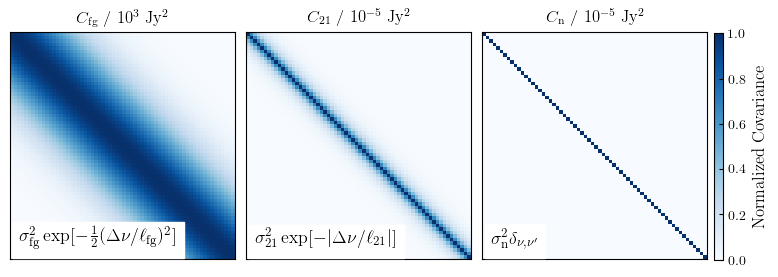

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=100)
fig.subplots_adjust(wspace=0.05)
cmap = 'Blues'
bbox = dict(pad=5, fc='w', ec='w', )

ax = axes[0]
ax.tick_params(direction='in', size=0, color='w')
cax = ax.imshow(F.C / F.C.max(), cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_xticklabels([]); ax.set_yticklabels([])
ax.set_title(r"$C_{{\rm fg}}\ /\ 10^{{{:.0f}}}\ {{\rm Jy^2}}$".format(np.log10(F.C.max())), fontsize=12)
ax.text(.04, .05, r"$\sigma_{\rm fg}^2\exp[-\frac{1}{2}(\Delta\nu/\ell_{\rm fg})^2]$", fontsize=13,
        transform=ax.transAxes, bbox=bbox)

ax = axes[1]
ax.tick_params(direction='in', size=0, color='w')
cax = ax.imshow(E.C / E.C.max(), cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_xticklabels([]); ax.set_yticklabels([])
ax.set_title(r"$C_{{\rm 21}}\ /\ 10^{{{:.0f}}}\ {{\rm Jy^2}}$".format(np.log10(E.C.max())), fontsize=12)
ax.text(.04, .05, r"$\sigma_{\rm 21}^2\exp[-|\Delta\nu/\ell_{\rm 21}|]$", fontsize=13,
        transform=ax.transAxes, bbox=bbox)

ax = axes[2]
ax.tick_params(direction='in', size=0, color='w')
cax = ax.imshow(N.C / N.C.max(), cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_xticklabels([]); ax.set_yticklabels([])
ax.set_title(r"$C_{{\rm n}}\ /\ 10^{{{:.0f}}}\ {{\rm Jy^2}}$".format(np.log10(N.C.max())), fontsize=12)
ax.text(.04, .05, r"$\sigma_{\rm n}^2\delta_{\nu,\nu^\prime}$", fontsize=13,
        transform=ax.transAxes, bbox=bbox)

cbax = fig.add_axes([0.85, 0.1, 0.067, 0.8])
cbax.axis('off')
cbar = fig.colorbar(cax, ax=cbax, aspect=25)
cbar.ax.tick_params(direction='in', size=3)
cbar.set_label("Normalized Covariance", fontsize=12, labelpad=6)

#fig.savefig("plots/covariances.pdf", dpi=100, bbox_inches='tight')

# GPR-FS and OQE comparison

In [11]:
## modulate noise and eor levels
fg_mult = 1e0
noise_mult = 1e2
noise_mult = 2e1
noise_mult = 1e0
eor_mult = 1e0

In [12]:
# generate data: only 100 channels across 10 MHz, but use wideband definition for consistency w/ wideband later on
freqs = np.linspace(130, 180, 100 * 5, endpoint=False)
#freqs = np.linspace(150, 160, 100, endpoint=False)
spw = slice(100 * 2, -100 * 2)

Nfreqs = len(freqs[spw])
Ntimes = 1000

D1, _, E1, _ = sqe.utils.gen_data(freqs * 1e6, Kfg, Keor1, Knoise, Ntimes=Ntimes, noise_mult=noise_mult,
                                  eor_mult=eor_mult, fg_mult=fg_mult, data_spw=spw, Omega_Eff=Oeff * Jy2mK**2)
G1 = copy.deepcopy(D1)

D2, F, E2, N = sqe.utils.gen_data(freqs * 1e6, Kfg, Keor2, Knoise, Ntimes=Ntimes, noise_mult=noise_mult,
                                  eor_mult=eor_mult, fg_mult=fg_mult, data_spw=spw, Omega_Eff=Oeff * Jy2mK**2)
G2 = copy.deepcopy(D2)
O2 = copy.deepcopy(D2)

In [43]:
_, Fw, _, _ = sqe.utils.gen_data(freqs[::5] * 1e6, Kfg, Keor1, Knoise, Ntimes=Ntimes, noise_mult=noise_mult,
                                  eor_mult=eor_mult, fg_mult=fg_mult, data_spw=None, Omega_Eff=Oeff * Jy2mK**2)
Fw.set_R(np.diag(uvt.dspec.gen_window('bh', 100)))
Fw.compute_Q()
Fw.compute_H()
Fw.compute_q()
Fw.compute_MWVp()

In [85]:
# generate weighting matrices
I = np.eye(Nfreqs)
t = np.diag(uvt.dspec.gen_window('bh', Nfreqs))
iC1 = np.linalg.inv(F.C + N.C + E1.C)
iC2 = np.linalg.inv(F.C + N.C + E2.C)
gp1 = I - F.C @ np.linalg.inv(F.C + N.C + E1.C)
gp2 = I - F.C @ np.linalg.inv((F.C + N.C + E2.C))

In [45]:
#c1 = O2.x1 - np.mean(O2.x1, axis=0, keepdims=True)
#c2 = O2.x2 - np.mean(O2.x2, axis=0, keepdims=True)
#cov = np.cov(O2.x1.T).real
#iC2 = np.linalg.inv(cov)

In [46]:
#lf = np.linalg.pinv(uvt.dspec.dayenu_mat_inv(G2.freqs*1e6, 0, 200e-9, 1e-9))

In [47]:
#gp1 = np.linalg.inv(Kn*nfac**2) @ gp1
#gp2 = np.linalg.inv(Kn*nfac**2) @ gp2

In [86]:
# set R
G1.set_R(gp1); G2.set_R(gp2); O2.set_R(iC2)
D1.set_R(t); D2.set_R(t); E1.set_R(t); E2.set_R(t); N.set_R(t)

In [113]:
# compute Q
G1.compute_Q()
D1.compute_Q()
E1.compute_Q()

G2.compute_Q()
O2.compute_Q()
D2.compute_Q()
E2.compute_Q()

N.compute_Q()

In [114]:
# compute H
G1.compute_H()
D1.compute_H()
E1.compute_H()

G2.compute_H()
O2.compute_H()
D2.compute_H()
E2.compute_H()

N.compute_H()

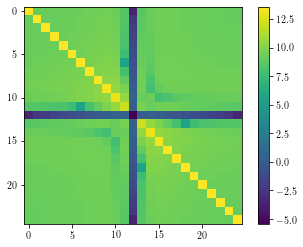

In [89]:
plt.imshow(np.log10(O2.H))
plt.colorbar()

In [115]:
# compute q
G1.compute_q()
D1.compute_q()
E1.compute_q()

G2.compute_q()
O2.compute_q()
D2.compute_q()
E2.compute_q()

N.compute_q()

In [116]:
# compute M, W, p, V, and spherically average
G1_normI, G1_normH = copy.deepcopy(G1), copy.deepcopy(G1)
G1_normI.compute_MWVp(norm='I', C_data=F.C + N.C + E1.C, C_bias=F.C)
G1_normH.compute_MWVp(norm='H^-1/2', C_data=F.C + N.C + E1.C, C_bias=F.C)

G2_normI, G2_normH = copy.deepcopy(G2), copy.deepcopy(G2)
G2_normI.compute_MWVp(norm='I', C_data=F.C + N.C + E2.C, C_bias=F.C)
G2_normH.compute_MWVp(norm='H^-1/2', C_data=(F.C + N.C + E2.C), C_bias=F.C)

O2.compute_MWVp(norm='H^-1/2', C_data=F.C + N.C + E2.C, C_bias=F.C)

In [65]:
O2.compute_MWVp(norm='I', C_data=F.C + N.C + E2.C, C_bias=F.C)

In [1483]:
G2_normI, G2_normH = copy.deepcopy(G2), copy.deepcopy(G2)
G2_normI.compute_MWVp(norm='I', C_data=F.C + N.C + E2.C, C_bias=F.C)
G2_normH.compute_MWVp(norm='H^-1/2', C_data=(F.C + N.C + E2.C), C_bias=F.C)

In [1454]:
u,s,v = np.linalg.svd(G2_normH.H)
M = v.T.conj() @ np.diag(1/np.sqrt(s)) @ u.T.conj()
W = M @ G2_normH.H
# normalize
M /= W.sum(axis=1)[:, None]

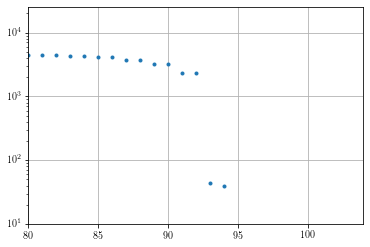

In [1455]:
plt.plot(s, ls='', marker='.')
plt.yscale('log')
plt.xlim(80, )
plt.ylim(1e1, )
plt.grid()

invalid value encountered in log10


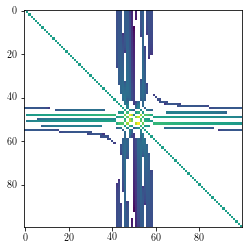

In [1464]:
n = 96
u, s, v = np.linalg.svd(G2_normH.H)
M = v.T.conj()[:, :n] @ np.diag(1/np.sqrt(s[:n])) @ u.T.conj()[:n, :]
W = M @ G2_normH.H
# normalize
M /= W.sum(axis=1)[:, None]
G2_normH.M = M
G2_normH.p = M @ G2_normH.q
G2_normH.W = W
plt.imshow(np.log10(M))

divide by zero encountered in log10
invalid value encountered in log10


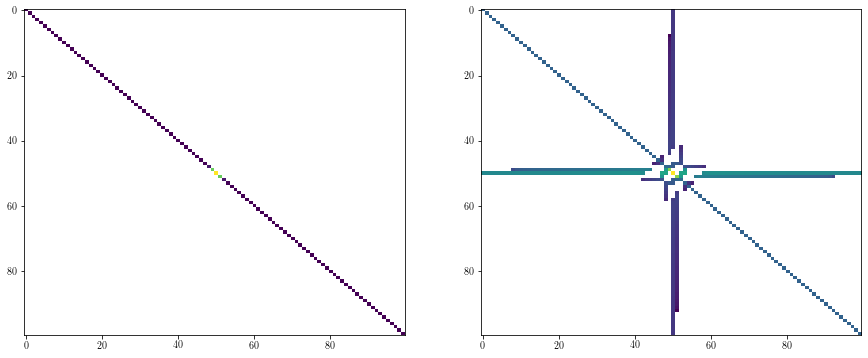

In [1491]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes[0]
ax.imshow(np.log10(np.real(G2_normI.M)), aspect='auto')
ax = axes[1]
ax.imshow(np.log10(np.real(G2_normH.M)), aspect='auto')

invalid value encountered in log10


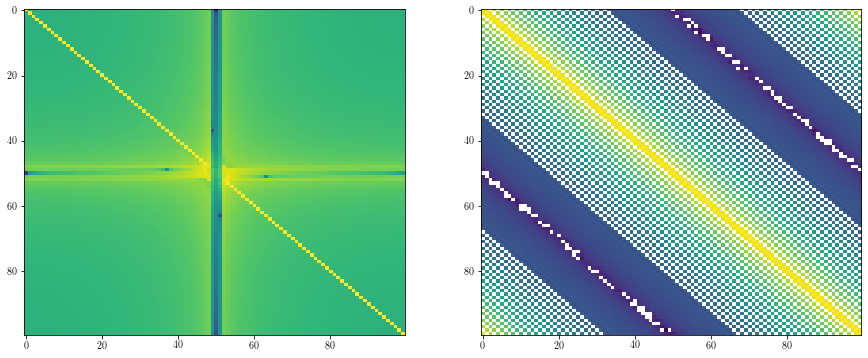

In [1568]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes[0]
ax.imshow(np.log10(np.real(G2_normI.W)), aspect='auto')
ax = axes[1]
ax.imshow(np.log10(np.real(O2.W)), aspect='auto')

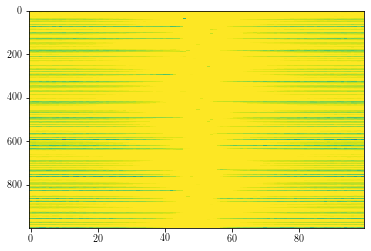

In [1569]:
plt.imshow(np.log10(np.real(G2_normI.p.T)), aspect='auto', vmin=2, vmax=8)

invalid value encountered in log10


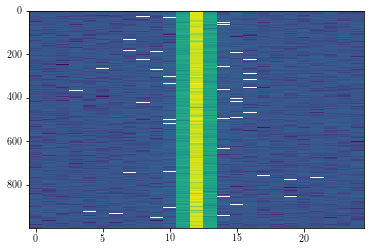

In [36]:
plt.imshow(np.log10(np.real(O2.p.T)), aspect='auto')#, vmin=2, vmax=8)

In [28]:
O2.V = np.eye(O2.spw_Nfreqs//2)

In [29]:
O2.spherical_average(kp_sph=np.unique(O2.kp_mag)[::1])

Casting complex values to real discards the imaginary part


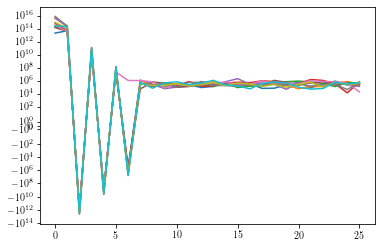

In [30]:
plt.plot(O2.p_sph[:, ::100]);
plt.yscale('symlog')

invalid value encountered in log10


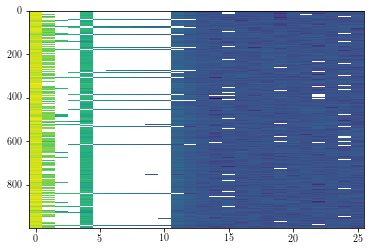

In [1588]:
plt.imshow(np.log10(np.real(O2.p_sph.T)), aspect='auto')#, vmin=2, vmax=8)

invalid value encountered in log10


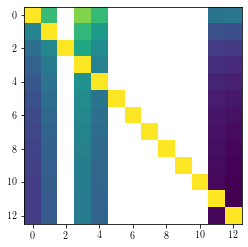

In [64]:
plt.imshow(np.log10(O2.W_sph.real))

In [57]:
D1.compute_MWVp(norm='I')
D2.compute_MWVp(norm='I')
E1.compute_MWVp(norm='I')
E2.compute_MWVp(norm='I')
N.compute_MWVp(norm='I')

Text(0.7, 0.8, '$M=H^{-1/2}$')

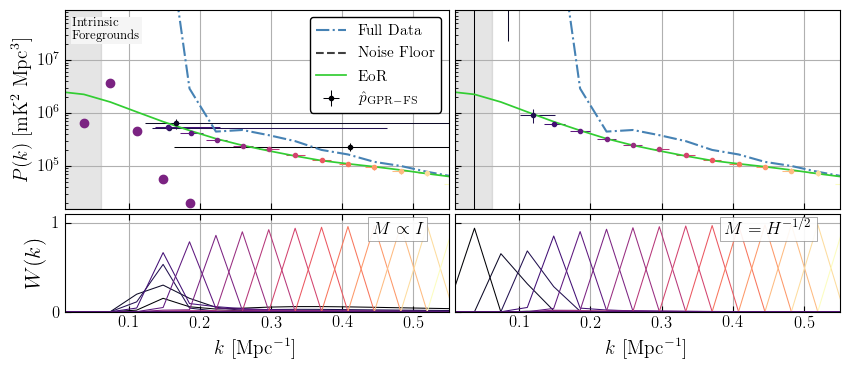

In [152]:
grid = gridspec.GridSpec(nrows=3, ncols=6)
fig = plt.figure(figsize=(10, 4), dpi=100)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

xticks = np.arange(0, 1.0, 0.1)
xlim = 0.01, 0.55
ylim = 1.5e4, 9e7
#ylim = None
ks = G2_normI.kp_sph > 0.03
bbox = dict(fc='w', ec='grey', alpha=0.9, pad=3, lw=.5)
prop_cycle = pt.matplotlib.Magma_15.mpl_colors
fg_k_ext = F.t2k / Kfg.k2.length_scale / 1.5

ax = fig.add_subplot(grid[:2, :3])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(0, fg_k_ext, color='k', alpha=0.1)
ax.text(0.02, 0.85, "Intrinsic\nForegrounds", rotation=0, fontsize=9, color='k', transform=ax.transAxes,
        bbox=dict(fc='whitesmoke', ec='None', alpha=1, pad=1, lw=.5))
p0 = ax.axhline(np.mean(np.abs(np.mean(N.p_sph - N.b_sph, axis=1).real)), c='k', ls='--', lw=1.5, alpha=0.75)
p1, = ax.plot(D2.kp_sph, np.abs(np.mean(D2.p_sph - D2.b_sph, axis=1).real), ls='-.', c='steelblue', lw=1.5, alpha=1)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, G2_normI.kp_sph, np.mean(G2_normI.p_sph - G2_normI.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(G2_normI.V_sph)/Ntimes), fmt='o', ms=3, elinewidth=0.75, W=G2_normI.W_sph, ks=ks)
p3, = ax.plot(E2.kp_sph, np.mean(E2.p_sph, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.legend([p1, p0, p3, p2[0]], ['Full Data', 'Noise Floor', 'EoR', r'$\hat{p}_{\rm GPR-FS}$'],
          fontsize=11, edgecolor='k', framealpha=1, borderpad=.4, loc=1)
ax.set_ylabel(r'$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$', fontsize=14)
#ax.plot(Fw.kp_sph, np.mean(Fw.p_sph, axis=1), c='k', lw=2)
ax.plot(G2_normI.kp_sph, np.mean(G2_normI.b_sph, axis=1))

ax = fig.add_subplot(grid[2:, :3])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(G2_normI.kp_sph, G2_normI.W_sph[ks].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(-.0, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=16)
ax.text(0.8, 0.8, r'$M \propto I$', fontsize=13, transform=ax.transAxes, bbox=bbox)

ax = fig.add_subplot(grid[:2, 3:])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(0, fg_k_ext, color='k', alpha=0.1)
p0 = ax.axhline(np.mean(np.abs(np.mean(N.p_sph - N.b_sph, axis=1).real)), c='k', ls='--', lw=1.5, alpha=0.75)
p1, = ax.plot(D2.kp_sph, np.abs(np.mean(D2.p_sph - D2.b_sph, axis=1).real), ls='-.', c='steelblue', lw=1.5, alpha=1)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, G2_normH.kp_sph, np.mean(G2_normH.p_sph - G2_normH.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(G2_normH.V_sph)/Ntimes), fmt='o', ms=3, elinewidth=0.75, W=G2_normH.W_sph, ks=ks)
p3, = ax.plot(E2.kp_sph, np.mean(E2.p_sph, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(grid[2:, 3:])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(G2_normH.kp_sph, G2_normH.W_sph[ks].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_yticklabels([])
ax.set_ylim(-.0, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.text(0.7, 0.8, r'$M=H^{-1/2}$', fontsize=13, transform=ax.transAxes, bbox=bbox)

#fig.savefig("plots/gpr_window_med_noise_ell075.pdf", dpi=100, bbox_inches='tight')

Text(0.7, 0.8, '$M=H^{-1/2}$')

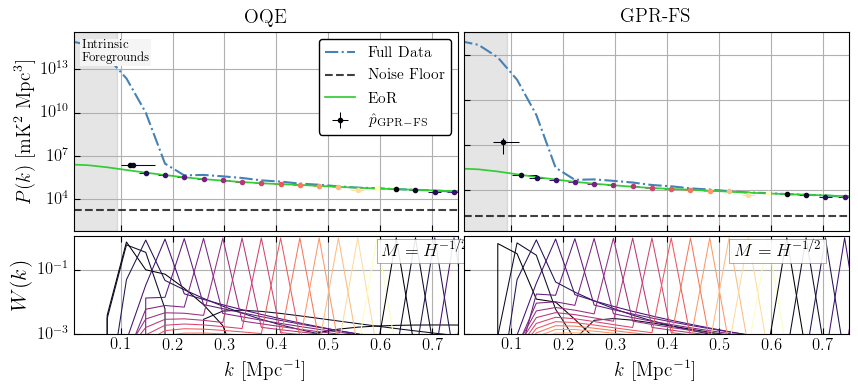

In [117]:
grid = gridspec.GridSpec(nrows=3, ncols=6)
fig = plt.figure(figsize=(10, 4), dpi=100)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

xticks = np.arange(0, 1.0, 0.1)
xlim = 0.01, 0.75
ylim = 3e4, 2e8
ylim = None
ks = O2.kp_sph > 0.04
bbox = dict(fc='w', ec='grey', alpha=0.9, pad=3, lw=.5)
prop_cycle = pt.matplotlib.Magma_15.mpl_colors
fg_k_ext = F.t2k / Kfg.k2.length_scale

ax = fig.add_subplot(grid[:2, :3])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(0, fg_k_ext, color='k', alpha=0.1)
ax.text(0.02, 0.85, "Intrinsic\nForegrounds", rotation=0, fontsize=9, color='k', transform=ax.transAxes,
        bbox=dict(fc='whitesmoke', ec='None', alpha=1, pad=1, lw=.5))
p0 = ax.axhline(np.median(np.abs(np.mean(N.p_sph - N.b_sph, axis=1).real)), c='k', ls='--', lw=1.5, alpha=0.75)
p1, = ax.plot(D2.kp_sph, np.abs(np.mean(D2.p_sph - D2.b_sph, axis=1).real), ls='-.', c='steelblue', lw=1.5, alpha=1)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, O2.kp_sph, np.mean(O2.p_sph - O2.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(O2.V_sph)/Ntimes), fmt='o', ms=3, elinewidth=0.75, W=O2.W_sph, ks=ks)
p3, = ax.plot(E2.kp_sph, np.mean(E2.p_sph, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.legend([p1, p0, p3, p2[0]], ['Full Data', 'Noise Floor', 'EoR', r'$\hat{p}_{\rm GPR-FS}$'],
          fontsize=11, edgecolor='k', framealpha=1, borderpad=.4)
ax.set_ylabel(r'$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$', fontsize=14)
#ax.plot(Fw.kp_sph, np.mean(Fw.p_sph, axis=1), c='k', lw=2)
ax.set_title("OQE", fontsize=14)

ax = fig.add_subplot(grid[2:, :3])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(O2.kp_sph, O2.W_sph[ks].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_ylim(1e-3, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=16)
ax.text(0.8, 0.8, r'$M = H^{-1/2}$', fontsize=13, transform=ax.transAxes, bbox=bbox)

ax = fig.add_subplot(grid[:2, 3:])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(0, fg_k_ext, color='k', alpha=0.1)
p0 = ax.axhline(np.median(np.abs(np.mean(N.p_sph - N.b_sph, axis=1).real)), c='k', ls='--', lw=1.5, alpha=0.75)
p1, = ax.plot(D2.kp_sph, np.abs(np.mean(D2.p_sph - D2.b_sph, axis=1).real), ls='-.', c='steelblue', lw=1.5, alpha=1)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, G2_normH.kp_sph, np.mean(G2_normH.p_sph - G2_normH.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(G2_normH.V_sph)/Ntimes), fmt='o', ms=3, elinewidth=0.75, W=G2_normH.W_sph, ks=ks)
p3, = ax.plot(E2.kp_sph, np.mean(E2.p_sph, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("GPR-FS", fontsize=14)

ax = fig.add_subplot(grid[2:, 3:])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(G2_normH.kp_sph, G2_normH.W_sph[ks].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_yticklabels([])
ax.set_ylim(1e-3, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.text(0.7, 0.8, r'$M=H^{-1/2}$', fontsize=13, transform=ax.transAxes, bbox=bbox)

#fig.savefig("plots/gpr_oqe_window_low_noise.pdf", dpi=100, bbox_inches='tight')

### compare to hera_pspec

In [4]:
uvd = UVData()
uvd.read("../data/noise001_sim.uvh5")

In [823]:
ds = hp.PSpecData([uvd], wgts=[None])
ds.set_spw((500, 564))
ds.set_weighting('iC')

In [826]:
key1 = key2 = (0, (0, 1))

In [827]:
ds.clear_cache()

In [828]:
Rkey = key1 + (ds.data_weighting,) + (ds.taper,)
ds._R[Rkey] = gp2

In [832]:
Gv = ds.get_G(key1, key2)
Hv = ds.get_H(key1, key2, sampling=True)
Mv, Wv = ds.get_MW(Gv, Hv, mode='I')

In [830]:
G2_normI.compute_p(norm='I', C_bias=F.C, C_data=F.C + N.C + E2.C, sph_avg=False)

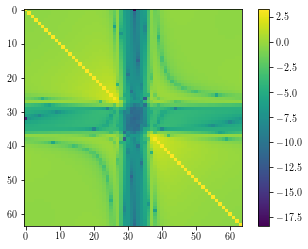

In [833]:
plt.imshow(np.log10(Hv.real))
plt.colorbar()

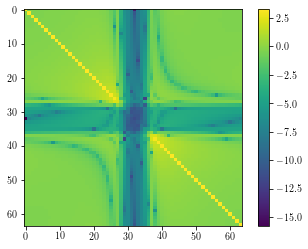

In [834]:
plt.imshow(np.log10(G2.H.real))
plt.colorbar()

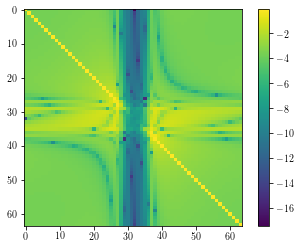

In [298]:
plt.imshow(np.log10(G2_normI.W.real))
plt.colorbar()

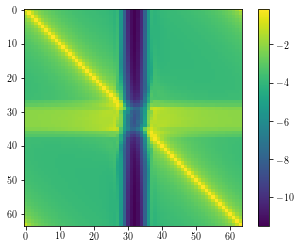

In [299]:
plt.imshow(np.log10(Wv.real))
plt.colorbar()

# wideband GPR-FS

In [373]:
## modulate noise and eor levels
fg_mult = 1e0
noise_mult = 1e2
#noise_mult = 2e1
eor_mult = 1e0

In [374]:
# generate data
freqs = np.linspace(130e6, 180e6, 100 * 5, endpoint=False)
#freqs = np.linspace(150, 160, 100, endpoint=False)

Nfreqs = len(freqs)
Ntimes = 1000
spw = slice(100 * 2, -100 * 2)
spw_Nfreqs = len(freqs[spw])

D2, F, E2, N = sqe.utils.gen_data(freqs, Kfg, Keor2, Knoise, Ntimes=Ntimes, noise_mult=noise_mult,
                                  eor_mult=eor_mult, fg_mult=fg_mult, data_spw=spw, Omega_Eff=Oeff * Jy2mK**2)
G2 = copy.deepcopy(D2)
G2w, Fw, E2w, Nw = sqe.utils.gen_data(freqs, Kfg, Keor2, Knoise, Ntimes=Ntimes, noise_mult=noise_mult,
                                      eor_mult=eor_mult, fg_mult=fg_mult, pspec_spw=spw, Omega_Eff=Oeff * Jy2mK**2)

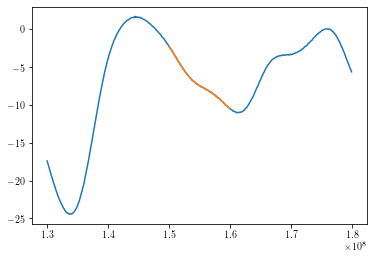

In [330]:
plt.plot(G2w.freqs, G2w.x1[0].real)
plt.plot(G2.freqs, G2.x1[0].real)

In [375]:
# generate weighting matrices
t = np.eye(spw_Nfreqs) * uvt.dspec.gen_window('bh', spw_Nfreqs)
gp2 = np.eye(spw_Nfreqs) - F.C @ np.linalg.inv(F.C + N.C + E2.C)
gp2w = np.eye(Nfreqs) - Fw.C @ np.linalg.inv(Fw.C + Nw.C + E2w.C)

In [376]:
lf = np.linalg.pinv(uvt.dspec.dayenu_mat_inv(G2.freqs*1e6, 0, 200e-9, 1e-9))
lfw = np.linalg.pinv(uvt.dspec.dayenu_mat_inv(G2w.freqs*1e6, 0, 200e-9, 1e-9))

In [377]:
# set R
G2.set_R(gp2); G2w.set_R(gp2w)
#G2.set_R(lf); G2w.set_R(lfw)
D2.set_R(t); E2.set_R(t); N.set_R(t)

In [378]:
# compute Q
G2.compute_Q()
G2w.compute_Q()
D2.compute_Q()
E2.compute_Q()
N.compute_Q()

In [379]:
# compute H
G2.compute_H()
G2w.compute_H()
D2.compute_H()
E2.compute_H()
N.compute_H()

In [380]:
# compute q
G2.compute_q()
G2w.compute_q()
D2.compute_q()
E2.compute_q()
N.compute_q()

In [381]:
# compute p
D2.compute_MWVp(norm='I')
E2.compute_MWVp(norm='I')
N.compute_MWVp(norm='I')

In [382]:
# compute MW and p
norm = 'H^-1'
norm = 'H^-1/2'
#norm = 'I'

G2.compute_MWVp(norm=norm, C_data=F.C + N.C + E2.C, C_bias=F.C)
G2w.compute_MWVp(norm=norm, C_data=Fw.C + Nw.C + E2w.C, C_bias=Fw.C)

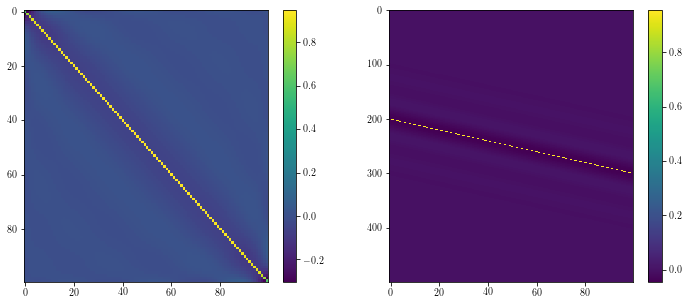

In [383]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cax = axes[0].imshow(np.real(G2.R.real.T), aspect='auto')
plt.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.real(G2w.R.real.T), aspect='auto')
plt.colorbar(cax, ax=axes[1])

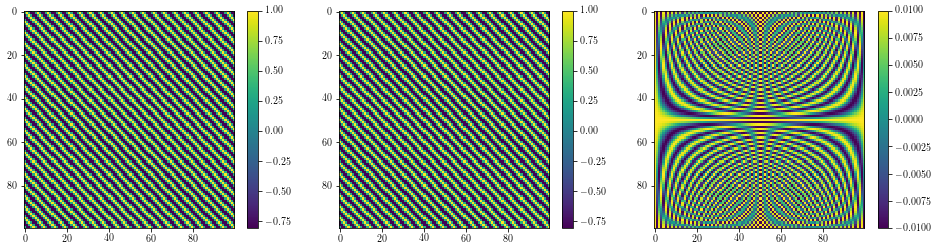

In [743]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
i = 30
cax = axes[0].imshow(G2.Q[i].real, aspect='auto')
plt.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(G2w.Q[i].real, aspect='auto')
plt.colorbar(cax, ax=axes[1])
cax = axes[2].imshow(G2.qft.real, aspect='auto')
plt.colorbar(cax, ax=axes[2])

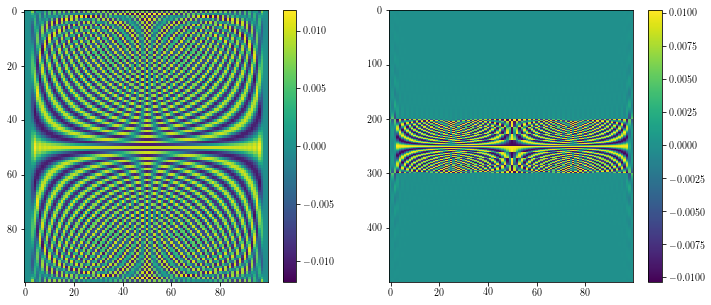

In [744]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
i = 30
cax = axes[0].imshow(np.real(G2.R.T @ G2.qft), aspect='auto')
plt.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.real(G2w.R.T @ G2w.qft), aspect='auto')
plt.colorbar(cax, ax=axes[1])

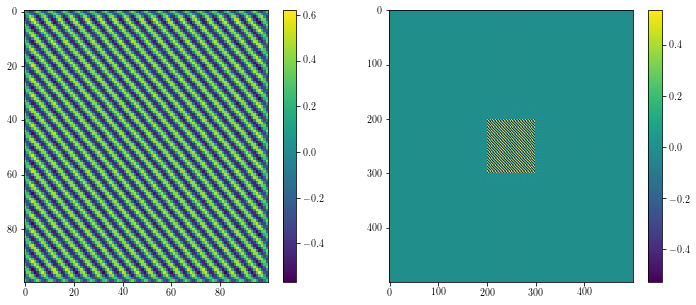

In [745]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
i = 32
cax = axes[0].imshow(np.real(G2.uE[i].real), aspect='auto')
plt.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.real(G2w.uE[i].real), aspect='auto')
plt.colorbar(cax, ax=axes[1])

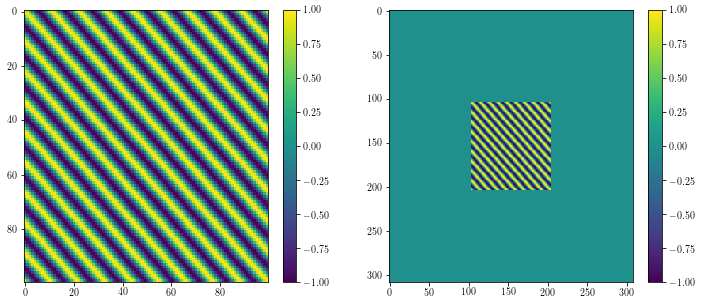

In [746]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
i = 41
cax = axes[0].imshow(np.real(G2.Q[i].real), aspect='auto')
plt.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.real(G2w.Q_zpad[i].real[96:-96, 96:-96]), aspect='auto')
plt.colorbar(cax, ax=axes[1])

invalid value encountered in log10


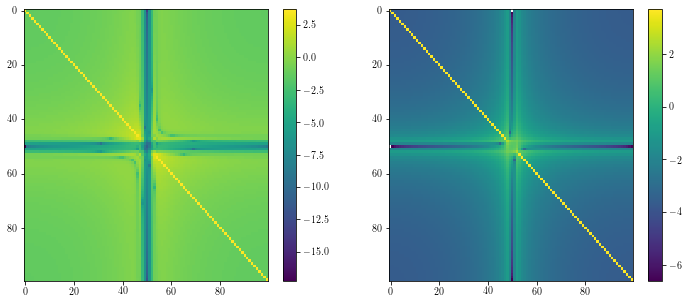

In [747]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cax = axes[0].imshow(np.log10(np.real(G2.H.real)), aspect='auto')
plt.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.log10(np.real(G2w.H.real)), aspect='auto')
plt.colorbar(cax, ax=axes[1])

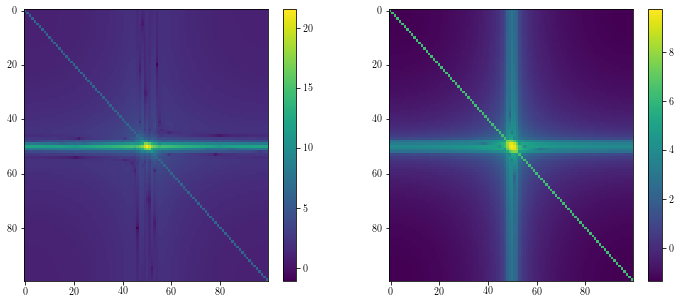

In [748]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cax = axes[0].imshow(np.log10(np.abs(G2.M)), aspect='auto')
plt.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.log10(np.abs(G2w.M)), aspect='auto')
plt.colorbar(cax, ax=axes[1])

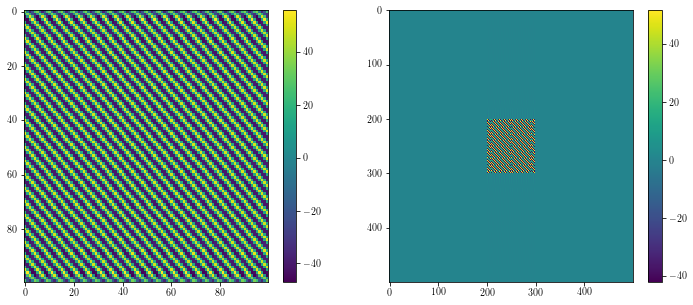

In [749]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
i = 30
cax = axes[0].imshow(np.real(G2.uE[i] @ G2.Q[i]), aspect='auto')
plt.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.real(G2w.uE[i] @ G2w.Q_zpad[i]), aspect='auto')
plt.colorbar(cax, ax=axes[1])

invalid value encountered in log10
invalid value encountered in log10


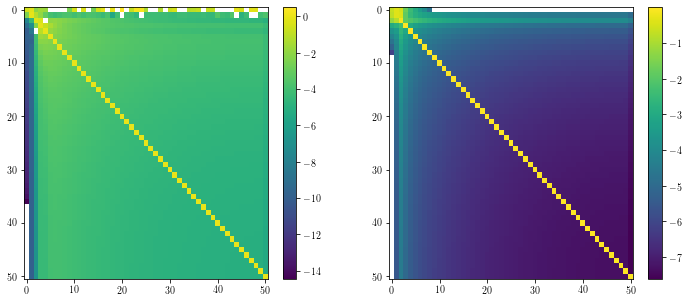

In [754]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cax = axes[0].imshow(np.log10(G2.W.real), aspect='auto')
plt.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.log10(G2w.W.real), aspect='auto')
plt.colorbar(cax, ax=axes[1])

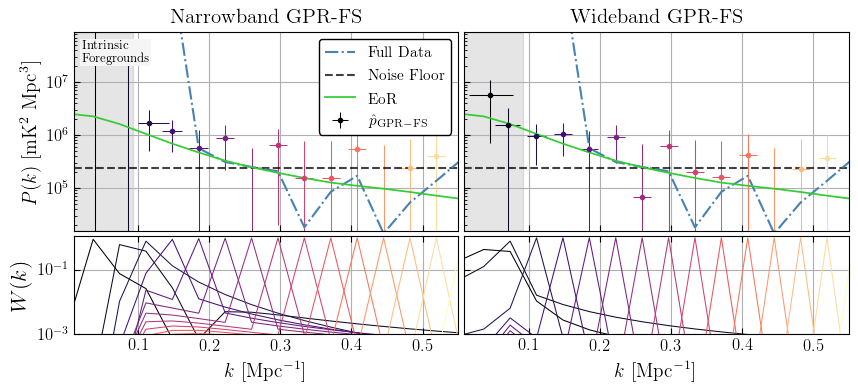

In [384]:
grid = gridspec.GridSpec(nrows=3, ncols=6)
fig = plt.figure(figsize=(10, 4), dpi=100)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

xticks = np.arange(0, 1.0, 0.1)
xlim = 0.01, 0.55
ylim = 1.5e4, 9e7
#ylim = None
ks = G2.kp_sph > 0.03
bbox = dict(fc='w', ec='grey', alpha=0.9, pad=3, lw=.5)
prop_cycle = pt.matplotlib.Magma_15.mpl_colors
fg_k_ext = F.t2k / Kfg.k2.length_scale

ax = fig.add_subplot(grid[:2, :3])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(0, fg_k_ext, color='k', alpha=0.1)
ax.text(0.02, 0.85, "Intrinsic\nForegrounds", rotation=0, fontsize=9, color='k', transform=ax.transAxes,
        bbox=dict(fc='whitesmoke', ec='None', alpha=1, pad=1, lw=.5))
p0 = ax.axhline(np.mean(np.abs(np.mean(N.p_sph - N.b_sph, axis=1).real)), c='k', ls='--', lw=1.5, alpha=0.75)
p1, = ax.plot(D2.kp_sph, np.abs(np.mean(D2.p_sph - D2.b_sph, axis=1).real), ls='-.', c='steelblue', lw=1.5, alpha=1)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, G2.kp_sph, np.mean(G2.p_sph - G2.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(G2.V_sph)/Ntimes), fmt='o', ms=3, elinewidth=0.75, W=G2.W_sph, ks=ks)
p3, = ax.plot(E2.kp_sph, np.mean(E2.p_sph, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.legend([p1, p0, p3, p2[0]], ['Full Data', 'Noise Floor', 'EoR', r'$\hat{p}_{\rm GPR-FS}$'],
          fontsize=11, edgecolor='k', framealpha=1, borderpad=.4)
ax.set_ylabel(r'$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$', fontsize=14)
#ax.plot(Fw.kp_sph, np.mean(Fw.p_sph, axis=1), c='k', lw=2)
ax.set_title("Narrowband GPR-FS", fontsize=15)

ax = fig.add_subplot(grid[2:, :3])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(G2.kp_sph, np.abs(G2.W_sph[ks].T), lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_ylim(1e-3, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=16)

ax = fig.add_subplot(grid[:2, 3:])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(0, fg_k_ext, color='k', alpha=0.1)
p0 = ax.axhline(np.mean(np.abs(np.mean(N.p_sph - N.b_sph, axis=1).real)), c='k', ls='--', lw=1.5, alpha=0.75)
p1, = ax.plot(D2.kp_sph, np.abs(np.mean(D2.p_sph - D2.b_sph, axis=1).real), ls='-.', c='steelblue', lw=1.5, alpha=1)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, G2w.kp_sph, np.mean(G2w.p_sph - G2w.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(G2w.V_sph)/Ntimes), fmt='o', ms=3, elinewidth=0.75, W=G2w.W_sph, ks=ks)
p3, = ax.plot(E2.kp_sph, np.mean(E2.p_sph, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Wideband GPR-FS", fontsize=15)

ax = fig.add_subplot(grid[2:, 3:])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(G2w.kp_sph, G2w.W_sph[ks].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_yticklabels([])
ax.set_ylim(1e-3, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)

#fig.savefig("plots/gpr_wideband_mednoise.pdf", dpi=100, bbox_inches='tight')

# inpainting

In [428]:
## modulate noise and eor levels
fg_mult = 1e0
noise_mult = 1e2
noise_mult = 2e1
eor_mult = 1e0

In [429]:
# generate data
freqs = np.linspace(130e6, 180e6, 100 * 5, endpoint=False)
#freqs = np.linspace(150, 160, 100, endpoint=False)

Nfreqs = len(freqs)
Ntimes = 1000
spw = slice(100 * 2, -100 * 2)
spw_Nfreqs = len(freqs[spw])

D2, F, E2, N = sqe.utils.gen_data(freqs, Kfg, Keor2, Knoise, Ntimes=Ntimes, noise_mult=noise_mult,
                                  eor_mult=eor_mult, fg_mult=fg_mult, data_spw=spw, Omega_Eff=Oeff * Jy2mK**2)
G2 = copy.deepcopy(D2)
G2w, Fw, E2w, Nw = sqe.utils.gen_data(freqs, Kfg, Keor2, Knoise, Ntimes=Ntimes, noise_mult=noise_mult,
                                      eor_mult=eor_mult, fg_mult=fg_mult, pspec_spw=spw, Omega_Eff=Oeff * Jy2mK**2)

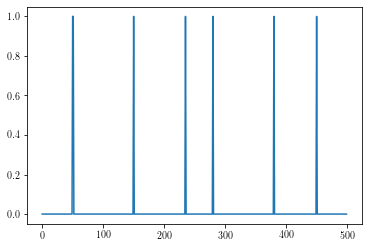

In [430]:
# generate flags
flags = np.zeros(Nfreqs, np.bool)

fchans = [(50, 52), (150, 151), (235, 236), (280, 281), (380, 381), (450, 451)]
for fc in fchans:
    flags[fc[0]:fc[1]] = True
    
plt.plot(flags)

In [431]:
# generate diagonal matrices
t = np.diag(uvt.dspec.gen_window('bh', spw_Nfreqs))
tw = np.diag(uvt.dspec.gen_window('bh', G2w.Nfreqs, edgecut_low=200, edgecut_hi=200))
I = np.eye(spw_Nfreqs)
Iw = np.eye(G2w.Nfreqs)

Wf, Wfw = I.copy(), Iw.copy()
Wf[~flags[spw], ~flags[spw]] = 0.0
Wfw[~flags, ~flags] = 0.0

Wuf, Wufw = I.copy(), Iw.copy()
Wuf[flags[spw], flags[spw]] = 0.0
Wufw[flags, flags] = 0.0

In [432]:
# get inpainting matrices across wide bandwidth
gpw_dm = (Fw.C) @ np.linalg.inv(Fw.C + Nw.C + E2w.C + Wfw * 1e5)
gpw_ip = Wufw + Wfw @ gpw_dm

In [433]:
G2w.set_R(tw @ gpw_ip)
G2w.compute_Q()
G2w.compute_H()
G2w.compute_q()
G2w.compute_MWVp(norm='I', C_bias=None, C_data=Fw.C + Nw.C + E2w.C)

In [434]:
D2.set_R(t); E2.set_R(t); N.set_R(t); G2.set_R(t @ Wuf)
D2.compute_Q(); E2.compute_Q(); N.compute_Q(); G2.compute_Q()
D2.compute_H(); E2.compute_H(); N.compute_H(); G2.compute_H()
D2.compute_q(); E2.compute_q(); N.compute_q(); G2.compute_q()
D2.compute_MWVp(norm='I', C_bias=None)
E2.compute_MWVp(norm='I', C_bias=None)
N.compute_MWVp(norm='I', C_bias=None)
G2.compute_MWVp(norm='I', C_bias=None, C_data=F.C + N.C + E2.C)

Casting complex values to real discards the imaginary part


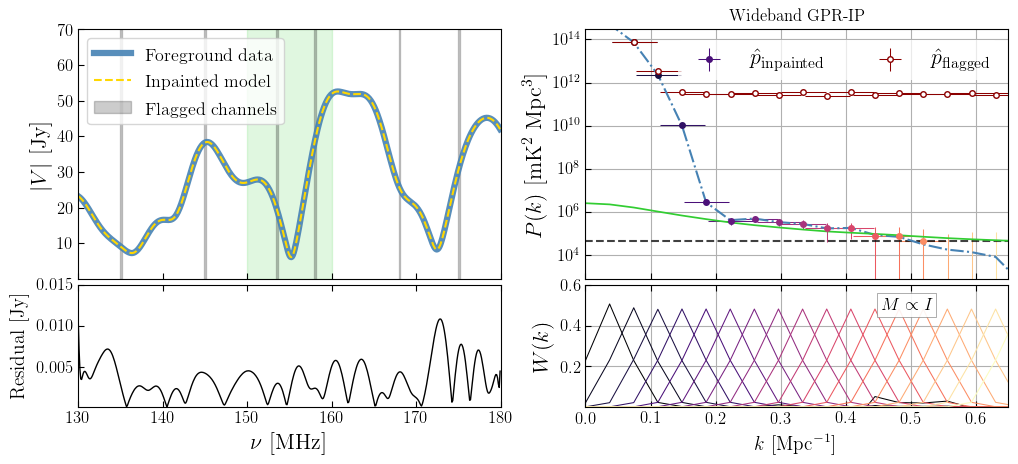

In [441]:
grid = gridspec.GridSpec(nrows=3, ncols=6)
fig = plt.figure(figsize=(12, 5), dpi=100)
fig.subplots_adjust(hspace=0.05, wspace=1)

xticks = np.arange(0, 1.0, 0.1)
xlim1 = 130, 180
xlim = 0, 0.65
ylim = 8e2, 3e14
#ylim = None
ks = (G2.kp_sph > 0.02) & (G2.kp_sph < 0.7)
bbox = dict(fc='w', ec='grey', alpha=0.9, pad=3, lw=.5)
prop_cycle = pt.matplotlib.Magma_18.mpl_colors

ax = fig.add_subplot(grid[:2, :3])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(150, 160, color='limegreen', alpha=0.15)
for fc in fchans:
    ax.axvspan(freqs[fc[0]-1]/1e6, freqs[fc[1]]/1e6, color='k', alpha=0.2)
d = G2w.x1[1].copy()
dip = gpw_dm @ d
d[flags] *= np.nan
p0, = ax.plot(Fw.freqs/1e6, np.abs(Fw.x1[1]), lw=4.5, color='steelblue', alpha=0.9)
p1, = ax.plot(Fw.freqs/1e6, np.abs(dip), lw=1.5, color='gold', ls='--')
r = plt.Rectangle((0,0), 0, 0, color='k', alpha=0.2)
ax.set_xlim(xlim1)
ax.set_ylim(0.1, 70)
ax.legend([p0, p1, r], ['Foreground data', 'Inpainted model', 'Flagged channels'], fontsize=13)
ax.set_ylabel(r'$|V|$ [Jy]', fontsize=16)
ax.set_xticklabels([])

ax = fig.add_subplot(grid[2:, :3])
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
#ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0e'))
ax.plot(Fw.freqs/1e6, np.abs(dip - Fw.x1[1]), color='k', lw=1)
ax.set_xlim(xlim1)
ax.set_ylim(0.0001, .015)
ax.set_xlabel(r'$\nu$ [MHz]', fontsize=16)
ax.set_ylabel(r'Residual [Jy]', fontsize=14, labelpad=5)

#ax2 = fig.add_axes([0.17, 0.55, 0.15, 0.3])
#ax2.tick_params(labelsize=10, direction='in', size=4)
#ax2.tick_params(which='minor', size=2, direction='in')
#ax2.plot(freqs, np.abs(d), lw=4, color='steelblue', alpha=0.7)
#ax2.plot(freqs, np.abs(dip), lw=1., color='darkmagenta')
#ax2.set_xlim(130, 132.5)
#ax2.set_ylim(11.5, 14)

ax = fig.add_subplot(grid[:2, 3:])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
p0 = ax.axhline(np.mean(np.abs(np.mean(N.p_sph - N.b_sph, axis=1).real)), c='k', ls='--', lw=1.5, alpha=0.75)
p1, = ax.plot(D2.kp_sph, np.abs(np.mean(D2.p_sph - D2.b_sph, axis=1).real), ls='-.', c='steelblue', lw=1.5, alpha=1)
p4, = ax.plot(E2.kp_sph, np.mean(E2.p_sph, axis=1).real, c='limegreen', lw=1.25)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, G2w.kp_sph, np.mean(G2w.p_sph - G2w.b_sph, axis=1), yerr=np.sqrt(np.diag(G2w.V_sph)/Ntimes),
              fmt='o', ms=4, elinewidth=0.75, ks=ks, W=G2w.W_sph)
p3 = errorbar(ax, G2.kp_sph, np.mean(G2.p_sph - G2.b_sph, axis=1), yerr=np.sqrt(np.diag(G2.V_sph)/Ntimes),
              fmt='o', ms=4, elinewidth=0.75, ks=ks, W=G2.W_sph, c='darkred', mfc='w')
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.legend([p2[4], p3[4]], [r'$\hat{p}_{\rm inpainted}$', r'$\hat{p}_{\rm flagged}$'],
          fontsize=16, edgecolor='none', framealpha=0.75, loc=0, ncol=2)
#ax.set_title(r'GPR Foreground Inpainting', fontsize=12)
ax.set_ylabel(r'$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$', fontsize=16)
ax.set_title("Wideband GPR-IP")

ax = fig.add_subplot(grid[2:, 3:])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(G2w.kp_sph, G2w.W_sph[ks].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
#ax.set_yscale('log')
ax.set_ylim(1e-3, 0.6)
ax.text(0.7, 0.8, r'$M\propto I$', fontsize=13, transform=ax.transAxes, bbox=bbox)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=16)

#fig.savefig("plots/gpr_inpaint_lownoise.pdf", dpi=100, bbox_inches='tight')

In [1006]:
# wideband GPR-FS with and without inpainting (inpaint FG and EoR)
gpw_dm = (Fw.C + E2w.C) @ np.linalg.inv(Fw.C + Nw.C + E2w.C + Wfw * 1e5)
gpw_ip = Wufw + Wfw @ gpw_dm

gpw_fs = Iw - Fw.C @ np.linalg.inv(Fw.C + Nw.C + E2w.C + Wfw * 1e5)
gpw_ip_fs = Iw - Fw.C @ np.linalg.inv(Fw.C + Nw.C + E2w.C)

In [1007]:
G2wip = copy.deepcopy(G2w)
G2wip.set_R(gpw_ip_fs @ gpw_ip)
G2wip.compute_H()
G2wip.compute_q()
G2wip.compute_MWVp(norm='H^-1/2', C_bias=Fw.C, C_data=Fw.C + Nw.C + E2w.C)

In [1018]:
G2wip.compute_MWVp(norm='I', C_bias=Fw.C, C_data=Fw.C + Nw.C + E2w.C)
G2w.compute_MWVp(norm='I', C_bias=Fw.C, C_data=Fw.C + Nw.C + E2w.C)

In [1008]:
G2w.set_R(gpw_fs)
G2w.compute_H()
G2w.compute_q()
G2w.compute_MWVp(norm='H^-1/2', C_bias=Fw.C, C_data=Fw.C + Nw.C + E2w.C)

In [1010]:
D2.set_R(t); E2.set_R(t); N.set_R(t)
D2.compute_H(); E2.compute_H(); N.compute_H()
D2.compute_q(); E2.compute_q(); N.compute_q()
D2.compute_MWVp(norm='I', C_bias=None)
E2.compute_MWVp(norm='I', C_bias=None)
N.compute_MWVp(norm='I', C_bias=None)

[]

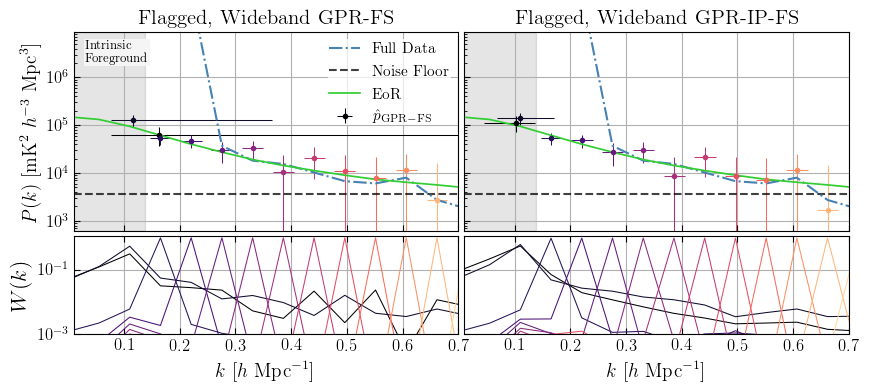

In [1021]:
grid = gridspec.GridSpec(nrows=3, ncols=6)
fig = plt.figure(figsize=(10, 4), dpi=100)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

xticks = np.arange(0, 1.0, 0.1)
xlim = 0.01, 0.7
ylim = 6e2, 9e6
#ylim = None
ks = G2.kp_sph > 0.03
bbox = dict(fc='w', ec='grey', alpha=0.9, pad=3, lw=.5)
prop_cycle = pt.matplotlib.Magma_14.mpl_colors
fg_k_ext = F.t2k / (Kfg.k2.length_scale * 1e6)

ax = fig.add_subplot(grid[:2, :3])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(0, fg_k_ext, color='k', alpha=0.1)
ax.text(0.03, 0.85, "Intrinsic\nForeground", rotation=0, fontsize=9, color='k', transform=ax.transAxes,
        bbox=dict(fc='whitesmoke', ec='None', alpha=1, pad=1, lw=.5))
p0 = ax.axhline(np.median(np.abs(np.mean(N.p_sph - N.b_sph, axis=1).real)), c='k', ls='--', lw=1.5, alpha=0.75)
p1, = ax.plot(D2.kp_sph, np.abs(np.mean(D2.p_sph - D2.b_sph, axis=1).real), ls='-.', c='steelblue', lw=1.5, alpha=1)
p3, = ax.plot(E2.kp_sph, np.mean(E2.p_sph, axis=1).real, c='limegreen', lw=1.25)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, G2w.kp_sph, np.mean(G2w.p_sph - G2w.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(G2w.V_sph)/Ntimes), fmt='o', ms=3, elinewidth=0.75, W=G2w.W_sph, ks=ks)
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.legend([p1, p0, p3, p2[0]], ['Full Data', 'Noise Floor', 'EoR', r'$\hat{p}_{\rm GPR-FS}$'],
          fontsize=11, edgecolor='none', framealpha=0.75, borderpad=.1)
ax.set_ylabel(r'$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=14)
ax.set_title("Flagged, Wideband GPR-FS", fontsize=15)

ax = fig.add_subplot(grid[2:, :3])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(G2w.kp_sph, G2w.W[ks].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(1e-3, 1.10)
ax.set_yscale('log')
ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=16)
#ax.text(0.7, 0.8, r'$M=H^{-1/2}$', fontsize=13, transform=ax.transAxes, bbox=bbox)

ax = fig.add_subplot(grid[:2, 3:])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(0, fg_k_ext, color='k', alpha=0.1)
p0 = ax.axhline(np.median(np.abs(np.mean(N.p_sph - N.b_sph, axis=1).real)), c='k', ls='--', lw=1.5, alpha=0.75)
p1, = ax.plot(D2.kp_sph, np.abs(np.mean(D2.p_sph - D2.b_sph, axis=1).real), ls='-.', c='steelblue', lw=1.5, alpha=1)
p3, = ax.plot(E2.kp_sph, np.mean(E2.p_sph, axis=1).real, c='limegreen', lw=1.25)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, G2wip.kp_sph, np.mean(G2wip.p_sph - G2wip.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(G2wip.V_sph)/Ntimes), fmt='o', ms=3, elinewidth=0.75, W=G2wip.W_sph, ks=ks)
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Flagged, Wideband GPR-IP-FS", fontsize=15)

ax = fig.add_subplot(grid[2:, 3:])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(G2wip.kp_sph, G2wip.W_sph[ks].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(1e-3, 1.10)
ax.set_yscale('log')
ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=14)
ax.set_yticklabels([])
#ax.text(0.7, 0.8, r'$M=H^{-1/2}$', fontsize=13, transform=ax.transAxes, bbox=bbox)

#fig.savefig("plots/gpr_wideband_lownoise.pdf", dpi=100, bbox_inches='tight')

# LOFAR GPR parameters

In [286]:
freqs = np.linspace(134e6, 146e6, 100)
Nfreqs = len(freqs)

In [287]:
beam = hp.PSpecBeamGauss(3 * np.pi / 180, freqs)  # 3 deg fwhm primary beam
Op, Opp = beam.get_Omegas(('xx', 'xx'))
Oeff = Op.mean()**2 / Opp.mean()
Jy2mK = beam.Jy_to_mK(freqs.mean(), pol='xx')[0]

In [21]:
# setup LOFAR covariances: Mertens+2020
nvar = 9e-5

Ks = (gp.kernels.ConstantKernel(611*nvar) * gp.kernels.RBF(length_scale=48))(freqs[:, None] / 1e6)
Km = (gp.kernels.ConstantKernel(50*nvar) * gp.kernels.Matern(length_scale=3, nu=3./2))(freqs[:, None] / 1e6)
Kf = Ks + Km
Kx = (gp.kernels.ConstantKernel(2.2*nvar) * gp.kernels.Matern(length_scale=0.26, nu=5./2))(freqs[:, None] / 1e6)
Ke = (gp.kernels.ConstantKernel(1*nvar) * gp.kernels.Matern(length_scale=0.7, nu=1./2))(freqs[:, None] / 1e6)
Kn = (gp.kernels.WhiteKernel(noise_level=nvar*1.2))(freqs[:, None] / 1e6)

In [22]:
Ntimes = 500
np.random.seed(10)
mean = np.zeros_like(freqs)
f = mn.rvs(mean, Kf/2, Ntimes) + 1j * mn.rvs(mean, Kf/2, Ntimes)
x = mn.rvs(mean, Kx/2, Ntimes) + 1j * mn.rvs(mean, Kx/2, Ntimes)
e = mn.rvs(mean, Ke/2, Ntimes) + 1j * mn.rvs(mean, Ke/2, Ntimes)
n = mn.rvs(mean, Kn/2, Ntimes) + 1j * mn.rvs(mean, Kn/2, Ntimes)

D = sqe.QE(freqs, f + x + e + n, C=Kf + Kx + Ke + Kn, Omega_Eff=Oeff * Jy2mK**2)
G = sqe.QE(freqs, f + x + e + n, C=Kf + Kx + Ke + Kn, Omega_Eff=Oeff * Jy2mK**2)
F = sqe.QE(freqs, f, C=Kf, Omega_Eff=Oeff * Jy2mK**2)
E = sqe.QE(freqs, e, C=Ke, Omega_Eff=Oeff * Jy2mK**2)
X = sqe.QE(freqs, x, C=Kx, Omega_Eff=Oeff * Jy2mK**2)
N = sqe.QE(freqs, n, C=Kn, Omega_Eff=Oeff * Jy2mK**2)

In [12]:
# generate weighting matrices
I = np.eye(Nfreqs)
t = np.diag(uvt.dspec.gen_window('bh', Nfreqs))
NEB = hc.vis_clean.noise_eq_bandwidth(t.diagonal())
gpr = (np.eye(Nfreqs) - F.C @ np.linalg.inv(D.C))
cov_err = (F.C - F.C @ np.linalg.inv(D.C) @ F.C)

In [13]:
# generate cov error term
ce = mn.rvs(mean, cov_err/2, Ntimes) + 1j * mn.rvs(mean, cov_err/2, Ntimes)
C = sqe.QE(freqs, ce, C=cov_err, Omega_Eff=Oeff * Jy2mK**2)

Casting complex values to real discards the imaginary part


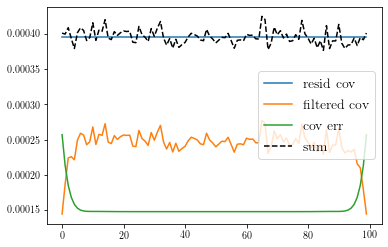

In [172]:
plt.plot((X.C+N.C+E.C).diagonal(), label="resid cov")
plt.plot(np.cov(gpr @ D.x1.T).diagonal(), label='filtered cov')
plt.plot(cov_err.diagonal(), label='cov err')
plt.plot(np.cov(gpr @ D.x1.T).diagonal() + cov_err.diagonal(), ls='--', c='k', label='sum')
plt.legend(fontsize=14)
#plt.ylim(0, 0.2)

## compare residual to bias corrected

In [180]:
# set R
G.set_R(gpr); D.set_R(t); E.set_R(I); N.set_R(I); C.set_R(I); F.set_R(t); X.set_R(I)
# compute H
G.compute_Q(); D.compute_Q(); E.compute_Q(); N.compute_Q(); C.compute_Q(); F.compute_Q(); X.compute_Q()
# compute H
G.compute_H(); D.compute_H(); E.compute_H(); N.compute_H(); C.compute_H(); F.compute_H(); X.compute_H()
# compute q
G.compute_q(); D.compute_q(); E.compute_q(); N.compute_q(); C.compute_q(); F.compute_q(); X.compute_q()

In [401]:
run_this_cell = False
if run_this_cell:
    E.compute_MWVp(norm='I', sph_avg=False)
    p = np.mean(E.p, axis=1)
    L = copy.deepcopy(G)
    L.H = np.array([[0.5 * np.trace(Qa @ Qb) - np.trace(cov_err @ Qa / p[i]) for i, Qb in enumerate(G.Q)] for Qa in G.Q])
    L.compute_MWVp(norm='I', sph_avg=False)
    G.compute_MWVp(norm='I', sph_avg=False)

Text(0.6, 0.45, '$d^TC_{,\\alpha}d$')

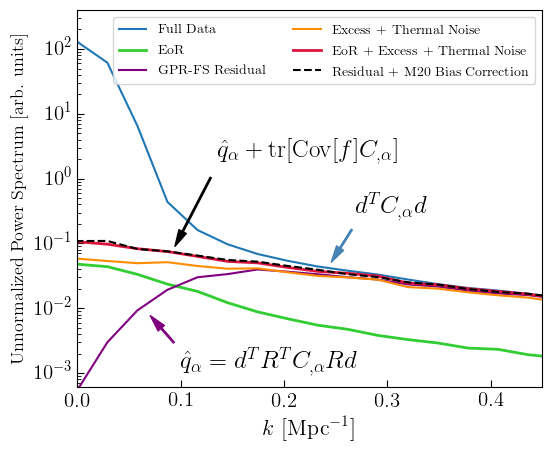

In [189]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.tick_params(labelsize=15, direction='in', size=5)
ax.tick_params(labelsize=15, direction='in', size=3, which='minor')

ax.plot(E.kp, np.mean(D.q, axis=1)*NEB**2, label='Full Data', lw=1.5)
ax.plot(N.kp, np.mean(E.q, axis=1), label='EoR', c='limegreen', lw=2)
ax.plot(G.kp, np.mean(G.q, axis=1), label='GPR-FS Residual', c='purple')
ax.plot(X.kp, np.mean(X.q + N.q, axis=1), label='Excess + Thermal Noise', ls='-', lw=1.5, c='darkorange')
ax.plot(X.kp, np.mean(E.q + X.q + N.q, axis=1), c='crimson', lw=2, label='EoR + Excess + Thermal Noise')
ax.plot(C.kp, np.mean(C.q + G.q, axis=1), c='k', ls='--',
        label=r'Residual + M20 Bias Correction', lw=1.5)

ax.legend(fontsize=10, ncol=2)
ax.set_yscale('log')
ax.set_xlim(0, 0.45)
ax.set_ylim(6e-4, 4e2)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'Unnormalized Power Spectrum [arb. units]', fontsize=13)

ax.annotate(r"$\hat{q}_\alpha = d^TR^TC_{,\alpha}Rd$", xytext=(0.22, 0.04), xy=(0.15, 0.2), fontsize=18,
            xycoords='axes fraction', textcoords='axes fraction', color='k',
            arrowprops=dict(color='purple', shrink=0.1, headwidth=6, width=1))
#ax.annotate(r"$d^TC_{,\alpha}d$", xytext=(0.25, 0.85), xy=(0.15, 0.75), fontsize=18,
#            xycoords='axes fraction', textcoords='axes fraction', color='k',
#            arrowprops=dict(color='steelblue', shrink=0.1, headwidth=6, width=1))
ax.annotate(r"$\hat{q}_\alpha + {\rm tr}[{\rm Cov}[f]C_{,\alpha}]$", xytext=(0.3, 0.6), xy=(0.2, 0.35), fontsize=18,
            xycoords='axes fraction', textcoords='axes fraction', color='k',
            arrowprops=dict(color='k', shrink=0.1, headwidth=6, width=1))
ax.annotate(r"$d^TC_{,\alpha}d$", xytext=(0.6, 0.45), xy=(0.54, 0.32), fontsize=18,
            xycoords='axes fraction', textcoords='axes fraction', color='k',
            arrowprops=dict(color='steelblue', shrink=0.1, headwidth=6, width=1))
#ax.annotate(r"$e^TC_{,\alpha}e$", xytext=(0.8, 0.35), xy=(0.7, 0.15), fontsize=18,
#            xycoords='axes fraction', textcoords='axes fraction', color='k',
#            arrowprops=dict(color='limegreen', shrink=0.1, headwidth=6, width=1))

#fig.savefig("plots/lofar_resid.pdf", dpi=100, bbox_inches='tight')

## plot window functions

In [996]:
# set R
G.set_R(gpr); E.set_R(I); N.set_R(I); C.set_R(I); X.set_R(I)
# compute H
G.compute_Q(); E.compute_Q(); N.compute_Q(); C.compute_Q(); X.compute_Q()
# compute H
G.compute_H(); E.compute_H(); N.compute_H(); C.compute_H(); X.compute_H()
# compute q
G.compute_q(); E.compute_q(); N.compute_q(); C.compute_q(); X.compute_q()
# compute p
E.compute_MWVp(norm='I')
N.compute_MWVp(norm='I', C_bias=N.C)
X.compute_MWVp(norm='I', C_bias=X.C)
C.compute_MWVp(norm='I')
# compute p
Gn1 = copy.deepcopy(G)
Gn2 = copy.deepcopy(G)
Gn1.compute_MWVp(norm='I',      C_bias=F.C + N.C, C_data=D.C, sph_avg=False)
Gn2.compute_MWVp(norm='H^-1/2', C_bias=F.C + N.C, C_data=D.C, sph_avg=False)

In [997]:
# spherical average
kp_mag = np.array([0.0, 0.025, 0.075, 0.0959, 0.133, 0.179, 0.238, 0.319, 0.432, 0.55, 0.75, 1.0])
kp_mag = np.array([0.0, 0.025, 0.075, 0.0979, 0.133, 0.179, 0.238, 0.319, 0.432, 0.55, 0.75, 1.0])
Gn1.spherical_average(kp_mag); Gn2.spherical_average(kp_mag)
N.spherical_average(kp_mag); X.spherical_average(kp_mag)

In [1034]:
Gn1.interp_k = sqe.utils.interp_Wcdf(Gn1.W_sph, Gn1.kp_sph)[0]

In [999]:
lofar_dsq = np.array([0, 0, 58.96**2, 95.21**2, 142.17**2, 235.80**2, 358.9**2, 505**2, 664**2, 0, 0, 0])
lofar_dsq_err = np.array([0, 0, 30.26**2, 33.98**2, 39.98**2, 51.81**2, 64**2, 87**2, 113**2, 0, 0, 0])

invalid value encountered in true_divide


Text(0.5, 0, '$k\\ [{\\rm Mpc}^{-1}]$')

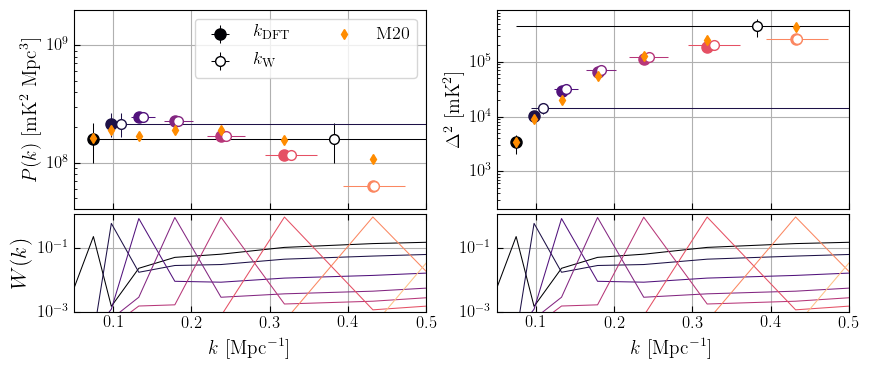

In [1056]:
grid = gridspec.GridSpec(nrows=3, ncols=6)
fig = plt.figure(figsize=(10, 4), dpi=100)
fig.subplots_adjust(hspace=0.05, wspace=1)

xticks = np.arange(0, 1.0, 0.1)
xlim = 0.05, 0.50
ks = Gn1.kp_sph > 0.03
bbox = dict(fc='w', ec='grey', alpha=0.9, pad=3, lw=.5)
prop_cycle = pt.matplotlib.Magma_9.mpl_colors

ax = fig.add_subplot(grid[:2, :3])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.set_prop_cycle('color', prop_cycle)
p1 = errorbar(ax, Gn1.kp_sph, np.mean(Gn1.p_sph - Gn1.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(Gn1.V_sph)/Ntimes), fmt='o', ms=8, elinewidth=0.75, ks=ks)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, Gn1.kp_sph, np.mean(Gn1.p_sph - Gn1.b_sph, axis=1).real, mfc='w',
              yerr=np.sqrt(np.diag(Gn1.V_sph)/Ntimes), fmt='o', ms=7, elinewidth=0.75, ks=ks, W=Gn1.W_sph)
p3 = ax.errorbar(kp_mag, lofar_dsq*2*np.pi**2/kp_mag**3, ms=5, fmt='d', color='darkorange')
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(4e7, 2e9)
ax.set_xticklabels([])
ax.set_ylabel(r'$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$', fontsize=14)
ax.legend([p1[0], p2[0], p3], [r"$k_{\rm DFT}$", r"$k_{\rm W}$", "M20"], fontsize=13, ncol=2)

ax = fig.add_subplot(grid[2:, :3])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(Gn1.kp_sph, np.abs(Gn1.W_sph[ks].T), lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_ylim(1e-3, 1.20)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=16)

ax = fig.add_subplot(grid[:2, 3:])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
Gn1.dsq_p, Gn1.dsq_b, Gn1.dsq_V = Gn1._compute_dsq(Gn1.kp_sph, Gn1.p_sph, Gn1.b_sph, Gn1.V_sph)
Gn1.dsq_p2, Gn1.dsq_b2, Gn1.dsq_V2 = Gn1._compute_dsq(Gn1.interp_k, Gn1.p_sph, Gn1.b_sph, Gn1.V_sph)
ax.set_prop_cycle('color', prop_cycle)
p1 = errorbar(ax, Gn1.kp_sph, np.mean(Gn1.dsq_p - Gn1.dsq_b, axis=1).real,
              yerr=np.sqrt(np.diag(Gn1.dsq_V)/Ntimes), fmt='o', ms=8, elinewidth=0.75, ks=ks)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, Gn1.kp_sph, np.mean(Gn1.dsq_p2 - Gn1.dsq_b2, axis=1).real, mfc='w',
              yerr=np.sqrt(np.diag(Gn1.dsq_V2)/Ntimes), fmt='o', ms=7, elinewidth=0.75, ks=ks, W=Gn1.W_sph)
p3 = ax.errorbar(kp_mag, lofar_dsq, ms=5, fmt='d', color='darkorange')
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(2e2, 9e5)
ax.set_xticklabels([])
#ax.legend([p1, p3, p2[0]], ['Full Data', 'EoR', r'$\hat{p}_{\rm GPR-FS}$'],
#          fontsize=11, edgecolor='k', framealpha=1, borderpad=.4)
ax.set_ylabel(r'$\Delta^2\ [{\rm mK}^2]$', fontsize=14)

ax = fig.add_subplot(grid[2:, 3:])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(Gn1.kp_sph, np.abs(Gn1.W_sph[ks].T), lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_ylim(1e-3, 1.20)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)

#fig.savefig("plots/lofar_rebinning.pdf", dpi=100, bbox_inches='tight')

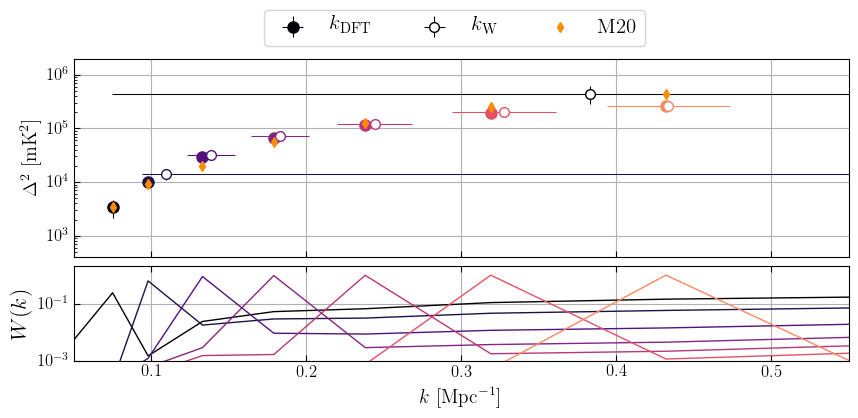

In [1094]:
grid = gridspec.GridSpec(nrows=3, ncols=6)
fig = plt.figure(figsize=(10, 4), dpi=100)
fig.subplots_adjust(hspace=0.1, wspace=1)

xticks = np.arange(0, 1.0, 0.1)
xlim = 0.05, 0.55
ks = (Gn1.kp_sph > 0.03) & (Gn1.kp_sph < 0.54)
bbox = dict(fc='w', ec='grey', alpha=0.9, pad=3, lw=.5)
prop_cycle = pt.matplotlib.Magma_9.mpl_colors

ax = fig.add_subplot(grid[:2, :])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
Gn1.dsq_p, Gn1.dsq_b, Gn1.dsq_V = Gn1._compute_dsq(Gn1.kp_sph, Gn1.p_sph, Gn1.b_sph, Gn1.V_sph)
Gn1.dsq_p2, Gn1.dsq_b2, Gn1.dsq_V2 = Gn1._compute_dsq(Gn1.interp_k, Gn1.p_sph, Gn1.b_sph, Gn1.V_sph)
ax.set_prop_cycle('color', prop_cycle)
p1 = errorbar(ax, Gn1.kp_sph, np.mean(Gn1.dsq_p - Gn1.dsq_b, axis=1).real,
              yerr=np.sqrt(np.diag(Gn1.dsq_V)/Ntimes), fmt='o', ms=8, elinewidth=0.75, ks=ks)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, Gn1.kp_sph, np.mean(Gn1.dsq_p2 - Gn1.dsq_b2, axis=1).real, mfc='w',
              yerr=np.sqrt(np.diag(Gn1.dsq_V2)/Ntimes), fmt='o', ms=7, elinewidth=0.75, ks=ks, W=Gn1.W_sph)
p3 = ax.errorbar(kp_mag, lofar_dsq, ms=5, fmt='d', color='darkorange')
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(4e2, 2e6)
ax.set_xticklabels([])
ax.set_ylabel(r'$\Delta^2\ [{\rm mK}^2]$', fontsize=14)
ax.legend([p1[0], p2[0], p3], [r"$k_{\rm DFT}$", r"$k_{\rm W}$", "M20"], fontsize=15, ncol=3,
          bbox_to_anchor=(0.25,0.8,0.5,0.5))

ax = fig.add_subplot(grid[2:, :])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(Gn1.kp_sph, np.abs(Gn1.W_sph[ks].T), lw=1., alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_ylim(1e-3, 2)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=16)

#fig.savefig("plots/lofar_rebinning.pdf", dpi=100, bbox_inches='tight')

In [1768]:
lofar_dsq = np.array([0, 0, 58.96**2, 95.21**2, 142.17**2, 235.80**2, 358.9**2, 505**2, 664**2, 0, 0, 0])
lofar_dsq_err = np.array([0, 0, 30.26**2, 33.98**2, 39.98**2, 51.81**2, 64**2, 87**2, 113**2, 0, 0, 0])
kfac = kp_mag**3 / (2 * np.pi**2)
kp_shift, _, _ = interp_Wcdf(Gn1.W, Gn1.kp_mag)
kfac_shift = kp_shift**3 / (2 * np.pi**2)
Gn1.p = lofar_dsq[:, None] / kfac[:, None]
Gn1.V = np.diag(lofar_dsq_err / kfac)**2
Gn2.p = lofar_dsq[:, None] / kfac[:, None]
Gn2.V = np.diag(lofar_dsq_err / kfac)**2

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


Text(0, 0.5, 'Window Function')

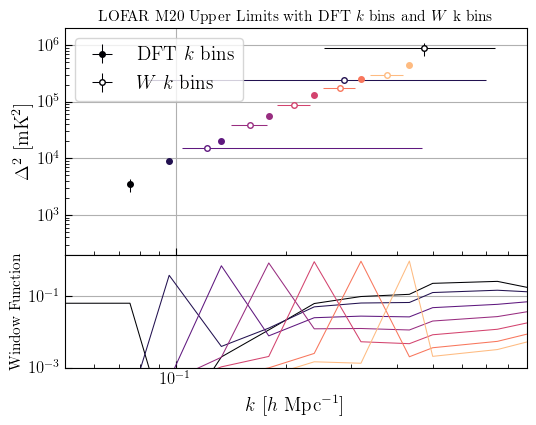

In [1777]:
grid = gridspec.GridSpec(nrows=3, ncols=6)
fig = plt.figure(figsize=(12, 4.5), dpi=100)
fig.subplots_adjust(hspace=0, wspace=0.05)

xticks_maj = [1e-1]
xticks_min = np.concatenate([np.arange(1e-2, 1e-1, 1e-2), np.arange(2e-1, 1e-0, 1e-1)])
yticks = np.logspace(1, 7, 7)
xlim = 5e-2, 0.9
ylim = 2e2, 2e6
#ylim = None
ks = (Gn1.kp_mag > 0.05) & (Gn1.kp_mag < 0.5)
bbox = dict(fc='w', ec='None', alpha=0.9, pad=1)
prop_cycle = pt.matplotlib.Magma_8.mpl_colors
xscale = 'log'

ax = fig.add_subplot(grid[:2, :3])
ax.tick_params(labelsize=12, direction='in', size=5, which='major')
ax.tick_params(which='minor', size=3, direction='in')
ax.set_prop_cycle('color', prop_cycle)
p1 = errorbar(ax, Gn1.kp_mag, Gn1.p[:, 0] * kfac, yerr=np.sqrt(np.diagonal(Gn1.V))*kfac,
              fmt='o', ms=4, elinewidth=0.75, ks=ks)
ax.set_prop_cycle('color', prop_cycle)
p2 = errorbar(ax, Gn1.kp_mag, Gn1.p[:, 0] * kfac_shift, yerr=np.sqrt(np.diagonal(Gn1.V))*kfac_shift,
              fmt='o', ms=4, elinewidth=0.75, ks=ks, mfc='w', W=Gn1.W)
ax.grid()
ax.set_xscale(xscale)
ax.set_xticks(xticks_maj); ax.set_xticks(xticks_min, minor=True)
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_yticks(yticks)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'$\Delta^2\ [{\rm mK}^2]$', fontsize=14)
ax.set_title(r"LOFAR M20 Upper Limits with DFT $k$ bins and $W$ k bins", fontsize=11)
ax.legend([p1[0], p2[0]], [r'DFT $k$ bins', r'$W$ $k$ bins'], fontsize=14, loc=2)

ax = fig.add_subplot(grid[2:, :3])
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=5)
ax.tick_params(which='minor', size=3, direction='in')
ax.plot(Gn1.kp_mag, Gn1.W[ks].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xscale(xscale)
ax.set_xticks(xticks_maj); ax.set_xticks(xticks_min, minor=True)
#ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_ylim(1e-3, 1.5)
#ax.text(0.7, 0.8, r'$M\propto I$', fontsize=12, transform=ax.transAxes, bbox=bbox)
ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel('Window Function', fontsize=11)

# gp regression tests

In [32]:
import gp_utils

In [33]:
imp.reload(gp_utils)

<module 'gp_utils' from '/lustre/aoc/projects/hera/nkern/gpr_errs_21cm/notebooks/gp_utils.py'>

In [34]:
freqs = np.linspace(134e6, 146e6, 64)
Nfreqs = len(freqs)

In [35]:
beam = hp.PSpecBeamGauss(3 * np.pi / 180, freqs)  # 3 deg fwhm primary beam
Op, Opp = beam.get_Omegas(('xx', 'xx'))
Oeff = Op.mean()**2 / Opp.mean()
Jy2mK = beam.Jy_to_mK(freqs.mean(), pol='xx')[0]

In [36]:
def PL(freqs, var, alpha):
    """
    A covariance model for a power-law in delay space
    """
    dnu = np.abs(freqs - freqs.T)
    dnu[np.isclose(dnu, 0)] = np.unique(dnu)[1] / 100
    pl = dnu**alpha
    pl *= 1 / pl[0, 0]
    return var * pl

In [37]:
def create_C(sigma_pl,kappa,N):
    U = np.identity(N)
    h_prev = 1
    for i in range(1,N):
        h = (i-kappa/2-1)/i * h_prev # Eq. (25)
        for j in range(0,N-i):
            U[j,j+i] = h
        h_prev = h
    U *= sigma_pl # scale noise
    return U.T @ U

In [38]:
# MCMC
def MCMC(G, D, nstep=600, init_theta=None, unlogged=True):
    samplers = []
    for i, (g, d) in enumerate(zip(G, D)):
        print("running iteration {}".format(i))
        g.prep_ydata(freqs[:, None]/1e6, d.x1.T);
        # generate starting pos for emcee chain
        nwalkers = 50
        if unlogged:
            theta = np.exp(g.kernel.theta)
            bounds = np.exp(g.kernel.bounds)
        else:
            theta = g.kernel.theta
            bounds = g.kernel.bounds
        if init_theta is None:
            start_vec = theta[1:]
        else:
            start_vec = init_theta[1:]
        ndims = start_vec.size
        offset = stats.norm.rvs(1, 0.1, nwalkers * ndims).reshape(nwalkers, ndims).clip(1e-10)
        if unlogged:
            start_pos = start_vec[None, :] * offset
        else:
            start_pos = np.log(np.exp(start_vec)[None, :] * offset)
        moves = emcee.moves.StretchMove(a=2.0)
        # run sampler
        Sampler = gp_utils.emcee_run(start_pos, g, nstep=nstep, unlogged=unlogged, theta_bounds=bounds,
                                     prepend=theta[0], moves=moves)
        Sampler.theta = theta
        samplers.append(Sampler)

    return samplers

def chain_CI(chain, ci=[0.95, 0.68]):
    """Get mode and confidence intervals from a markov chain
    Parameters
        chain : array-like, (Niterations, Nparams)
        ci : list of float, list of confidence intervals
    Returns
        modes, intervals, chain_ci
    """
    # get mode by histogramming near median
    med = np.median(chain, axis=0)
    std = np.sqrt(astats.biweight_midvariance(chain - med, axis=0))
    modes = []
    for i in range(chain.shape[1]):
        y, x = np.histogram(chain[:, i], bins=15, range=(med[i]-2*std[i], med[i]+2*std[i]), density=True)
        x = x[:-1] + np.diff(x)[0]/2
        modes.append(x[np.argmax(y)])
    modes = np.array(modes)
    # order the chain and integrate to get confidence intervals
    ordered_chain = chain - modes
    for i in range(ordered_chain.shape[1]):
        ordered_chain[:, i] = ordered_chain[:, i][np.argsort(np.abs(ordered_chain[:, i]))]
    
    chain_ci = [ordered_chain[:int(chain.shape[0] * _ci)] + modes for _ci in ci]
    intervals = np.moveaxis([(ch_ci.min(axis=0), ch_ci.max(axis=0)) for ch_ci in chain_ci], -1, 0)
    return modes, intervals

def analyze_chain(samplers, nburn=200, ci=[0.95, 0.68], param_inds=None, norm_inds=[]):
    chains, truths, new_labels = [], [], []
    modes, intervals, chain_ci = [], [], []
    for i, sampler in enumerate(samplers):
        ndim = sampler.chain.shape[-1]
        if param_inds is None:
            inds = range(ndim)
        else:
            inds = param_inds
        good_chains = ~(sampler.acceptance_fraction < 0.05)
        chain = sampler.chain[good_chains][:, nburn:, inds]
        ndim = chain.shape[-1]
        chain = chain.reshape(-1, ndim)
        # re-normalize
        new_label = [labels[1:][j] for j in inds]
        truth = sampler.theta[1:][inds]
        for j in norm_inds:
            chain[:, j] = np.sqrt(chain[:, j] / sampler.theta[0])
            truth[j] = np.sqrt(truth[j] / sampler.theta[0])
            new_label[j] = new_label[j][:-3] + r'/\sigma_n$'
        chains.append(chain)
        truths.append(truth)
        new_labels.append(new_label)
        mode, interval = chain_CI(chain, ci=ci)
        modes.append(mode)
        intervals.append(interval)
    return chains, truths, new_labels, modes, intervals

In [91]:
def gen_axes(fig, ndim, lower_left=(0, 0), dwidth=0.1, dheight=0.1, wspace=0, hspace=0):
    axes = []
    left, bottom = lower_left[0], lower_left[1]
    for i in range(ndim):
        _axes = []
        left = lower_left[0]
        for j in range(ndim):
            _axes.append(fig.add_axes([left, bottom, dwidth, dheight]))
            left += dwidth + wspace
        bottom += dheight + hspace
        axes.append(_axes)
    return np.array(axes[::-1])
    
def corner_plot(chain, labels, fname=None, fig=None, thin=1, truths=None, tls=8, buff=3, **kwargs):
    ndims = chain.shape[1]
    if fig is None:
        fig, axes = plt.subplots(ndims, ndims, figsize=(6, 6), dpi=100)
    else:
        axes = np.reshape(fig.get_axes(), (ndims, ndims))
    med, std = np.median(chain, axis=0), np.sqrt(astats.biweight_midvariance(chain, axis=0))
    ranges = np.array([med-std*buff, med+std*buff]).T
    ranges = (np.quantile(chain, [.05, .95], axis=0) - np.median(chain, axis=0))*buff + np.median(chain, axis=0)
    ranges = ranges.T

    _ = corner.corner(chain[::thin], fig=fig, range=ranges, **kwargs)

    fig.subplots_adjust(wspace=0.06, hspace=0.06)
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            if j > i: continue
            ax = axes[i, j]
            ax.tick_params(labelsize=tls, direction='in', top=True, right=True)
            if j == 0 and i > 0:
                ax.set_ylabel(labels[i], fontsize=16, labelpad=5)
            if i == axes.shape[0]-1:
                ax.set_xlabel(labels[j], fontsize=16, labelpad=5)
            if truths is not None:
                ax.axvline(truths[j], color='indianred', lw=1.5, alpha=0.75)
                if j < i:
                    ax.axhline(truths[i], color='indianred', lw=1.5, alpha=0.75)
    if fname is not None:
        fig.savefig(fname, dpi=100, bbox_inches='tight')
        
def hist_ci(ax, samples, bins, range, ci=None):
    """
    samples : array-like (Nsamples,)
    bins : int
    range : tuple
    ci : list of array-like, (Nintervals, 2)
    """
    out = np.histogram(samples, bins=bins, range=range, density=True)
    x, y = out[1][:-1], out[0]
    for _ci in ci:
        index = np.argmin(np.abs(x - _ci[0])), np.argmin(np.abs(x - _ci[1]))
        ax.bar(x[index[0]:index[1]], y[index[0]:index[1]], width=np.diff(x)[0], align='edge',
               color='steelblue', alpha=0.25, fill=True)
    ax.hist(samples, bins=bins, range=range, density=True, histtype='step', color='k', lw=1.)

In [40]:
def setup_gpr_data(freqs, nvar=9e-5, ncoeff=1.2, Ntimes=1, Nuv=50, seed=0,
                   ell_eor=1, ell_bounds=[0.1, 1.2], var_eor=2.2, PL_eor=None,
                   var_tone=None, k_tone=0.075, sky_var=611, sky_len=50, sky_len_bounds=(10, 100),
                   mix_var=50, mix_len=3, mix_len_bounds=(1, 10),
                   ex_var=2.2, ex_len=0.26, ex_len_bounds=(0.2, 0.8)):
    global labels, theta_bounds
    # setup LOFAR covariances: Mertens+2020
    Ksky = gp.kernels.ConstantKernel(sky_var*nvar, (sky_var*nvar*1e-2, sky_var*nvar*1e2)) \
            * gp.kernels.RBF(sky_len, sky_len_bounds)
    Ksky.labels = [r'$\sigma_{\rm sky}^2$', r'$\ell_{\rm sky}$']
    Ks = Ksky(freqs[:, None] / 1e6)
    Kmix = gp.kernels.ConstantKernel(mix_var*nvar, (mix_var*nvar*1e-2, mix_var*nvar*1e2)) \
            * gp.kernels.Matern(mix_len, mix_len_bounds, 3./2)
    Kmix.labels = [r'$\sigma_{\rm mix}^2$', r'$\ell_{\rm mix}$']
    Km = Kmix(freqs[:, None] / 1e6)
    Kfg = Ksky + Kmix
    Kfg.labels = Ksky.labels + Kmix.labels
    Kf = Ks + Km

    Kex = gp.kernels.ConstantKernel(ex_var*nvar, (ex_var*nvar*1e-2, ex_var*nvar*1e2)) \
            * gp.kernels.Matern(ex_len, ex_len_bounds, 5./2)
    Kex.labels = [r'$\sigma_{\rm X}^2$', r'$\ell_{\rm X}$']
    Kx = Kex(freqs[:, None] / 1e6)

    Keor = gp.kernels.ConstantKernel(var_eor*nvar, (var_eor*nvar*1e-2, var_eor*nvar*1e2)) \
            * gp.kernels.Matern(ell_eor, ell_bounds, 1./2)
    Ke = Keor(freqs[:, None] / 1e6)
    Keor.labels = [r'$\sigma_{\rm 21}^2$', r'$\ell_{\rm 21}$']
    if PL_eor is not None:
        Ke = PL(freqs[:, None]/1e6, var_eor*nvar, -(1+PL_eor))

    Knoise = gp.kernels.WhiteKernel(nvar*ncoeff, [nvar*ncoeff*0.9999, nvar*ncoeff*1.0001])
    Knoise.labels = [r'$\sigma_{\rm N}^2$']
    Kn = Knoise(freqs[:, None] / 1e6)
    kdict = dict(Ksky=Ksky, Kmix=Kmix, Keor=Keor, Knoise=Knoise, Kfg=Kfg, Kex=Kex)

    # tone injection
    if var_tone is not None:
        cosmo = sqe.utils.Cosmology()
        tau_tone = k_tone / cosmo.tau_to_kpara(cosmo.f2z(freqs.mean()))
        C_tone = lambda f: var_tone * nvar * np.exp(2j*np.pi*(f - f.T) * tau_tone)
        C_t = C_tone(freqs[:, None]).real
        Ke += C_t
    
    # generate data
    # covariances don't get /=2 b/c they represent variance in real and imag separately
    np.random.seed(seed)
    mean = np.zeros_like(freqs)
    # sky is uncorrelated across uv, but constant time-to-time
    f = mn.rvs(mean, Kf, Nuv) + 1j * mn.rvs(mean, Kf, Nuv)
    f = np.repeat(f, Ntimes, axis=0)
    e = mn.rvs(mean, Ke, Nuv) + 1j * mn.rvs(mean, Ke, Nuv)
    e = np.repeat(e, Ntimes, axis=0)
    # noise is uncorrelated across uv and times
    x = mn.rvs(mean, Kx, Ntimes * Nuv) + 1j * mn.rvs(mean, Kx, Ntimes * Nuv)
    n = mn.rvs(mean, Kn, Ntimes * Nuv) + 1j * mn.rvs(mean, Kn, Ntimes * Nuv)
    D = sqe.QE(freqs, f + x + e + n, C=Kf + Kx + Ke + Kn, Omega_Eff=Oeff * Jy2mK**2)
    F = sqe.QE(freqs, f, C=Kf, Omega_Eff=Oeff * Jy2mK**2)
    N = sqe.QE(freqs, n, C=Kn, Omega_Eff=Oeff * Jy2mK**2)
    X = sqe.QE(freqs, x, C=Kx, Omega_Eff=Oeff * Jy2mK**2)
    E = sqe.QE(freqs, e, C=Ke, Omega_Eff=Oeff * Jy2mK**2)
    
    # setup GP model
    optimizer = 'fmin_l_bfgs_b'
    n_restarts = 10
    norm_y = False
    Kmodel = ['Knoise', 'Kfg', 'Kex', 'Keor']
    G, Knames, labels, theta_bounds = gp_utils.setup_gp(Kmodel, kdict, optimizer=optimizer,
                                                        n_restarts=n_restarts, norm_y=norm_y)    
    return G, D, F, E, X, N, Knames

In [41]:
def pspec_run(d, r, kernel=None, fg_Kname=None, norm=None, Ntimes=1, Nuv=200):
    """
    Parameters
    ----------
    d : QE object
    r : str, ['t', 'I', 'gpr']
    kernel : GP kernel object, used for gpr and cov_err. If fed as a list, will iterate
    fg_Kname : str, foreground subkernel index of kernel, used for gpr and cov_err
    """
    # setup weighting matrices
    t = np.diag(uvt.dspec.gen_window('bh', d.Nfreqs))
    NEB = hc.vis_clean.noise_eq_bandwidth(t.diagonal())
    I = np.eye(d.Nfreqs)
    cov_err = None
    # iterate over kernel if provided
    if not isinstance(kernel, list):
        kernel = [kernel]
    for i, kern in enumerate(kernel):
        if r == 'I':
            d.set_R(I)
        elif r == 't':
            d.set_R(t)
            d.NEB = NEB
        elif r == 'gpr':
            Cf = gp_utils.get_kernel(kern, fg_Kname)(d.freqs[:, None]/1e6) * 2
            Cd = kern(freqs[:, None]/1e6) * 2
            gpr = (I - Cf @ np.linalg.inv(Cd))
            cov_err = (Cf - Cf @ np.linalg.inv(Cd) @ Cf)
            d.set_R(gpr)
        # QE
        d.compute_Q()
        d.compute_H()
        # if running multiple kernels, make a list
        # compute q
        if hasattr(d, 'q'):
            if isinstance(d.q, np.ndarray):
                d.q = [d.q]
        else:
            d.q = []
        d.q.append(d._compute_q(d.x1, d.x2, d.uE))
        # add cov_err if necessary
        if cov_err is not None:
            d.cov_err = cov_err
            ce = mn.rvs(np.zeros(d.Nfreqs), cov_err/2, Ntimes*Nuv) \
                    + 1j * mn.rvs(np.zeros(d.Nfreqs), cov_err/2, Ntimes*Nuv)
            ce = sqe.QE(freqs, ce, C=cov_err, Omega_Eff=Oeff * Jy2mK**2)
            ce.set_R(np.eye(d.Nfreqs)); ce.compute_Q(); ce.compute_H(); ce.compute_q()
            if hasattr(d, 'q_corr'):
                if isinstance(d.q_corr, np.ndarray):
                    d.q_corr = [d.q_corr]
            else:
                d.q_corr = []
            d.q_corr.append(d.q[i] + ce.q)
        # compute p
        if norm is not None:
            d.compute_MW(norm=norm)
            if hasattr(d, 'p'):
                if isinstance(d.p, np.ndarray):
                    d.p = [d.p]
                    d.b = [d.b]
            else:
                d.p, d.b = [], []
            d.b.append(d._compute_b(Cf, d.E)[:, None])
            d.p.append(d._compute_p(d.M, d.q[i]))
    # compute std over kernels
    d.q_err = np.std(d.q, axis=0)
    d.q = d.q[0]
    if cov_err is not None:
        d.q_corr_err = np.std(d.q_corr, axis=0)
        d.q_corr = d.q_corr[0]
    if norm is not None:
        d.p_err = np.std(d.p, axis=0)
        d.p, d.b = d.p[0], d.b[0]

## vanilla FG, EoR and Noise model

In [1104]:
%%time
# M18 vanilla FG, EoR and Noise
D, G, E, S, F, N, X = [], [], [], [], [], [], []
Ntimes, Nuv = 1, 200
nvar = 4e-5
ell_eor = [0.5, 4.0, 12.0]
var_eor = [1.0, 2.0, 2.0]

for i, (e_ell, e_var) in enumerate(zip(ell_eor, var_eor)):
    # setup data
    (g, d, f, e, x, n,
     Knames) = setup_gpr_data(freqs, nvar=nvar, ncoeff=2, Ntimes=Ntimes, Nuv=Nuv,
                              ell_eor=e_ell, var_eor=e_var, ell_bounds=[0.1, 1.2],
                              sky_var=38, sky_len=80, sky_len_bounds=(60, 100),
                              mix_var=1.5, mix_len=2, mix_len_bounds=(1.5, 2.5),
                              ex_var=1e-10)            
    s = copy.deepcopy(d)

    # setup priors
    #g.theta_priors = [None, None, None, None, None, None, None, None, gp_utils.log_gauss(0.5, 0.05)]
    g.theta_priors = None
    
    # optimize kernel
    yfit = g.prep_ydata(freqs[:, None] / 1e6, d.x1.T)
    init_theta = g.kernel.theta
    init_theta[-1] = np.log(0.5)
    g.fit(freqs[:, None] / 1e6, yfit, init_theta=init_theta)

    # QE
    pspec_run(d, 'gpr', g.kernel_, Knames[1], norm='H^-1/2', Ntimes=Ntimes, Nuv=Nuv)
    pspec_run(e, 't')
    pspec_run(s, 't')
    pspec_run(f, 't')
    pspec_run(n, 'I')
    pspec_run(x, 'I')

    G.append(g)
    D.append(d); E.append(e); S.append(s); F.append(f); N.append(n); X.append(x)

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


CPU times: user 1min 47s, sys: 1min 29s, total: 3min 16s
Wall time: 25.4 s


In [1105]:
print(G[0].kernel.k2, G[1].kernel.k2)
print(G[0].kernel_.k2, G[1].kernel_.k2)

0.00632**2 * Matern(length_scale=0.5, nu=0.5) 0.00894**2 * Matern(length_scale=4, nu=0.5)
0.00709**2 * Matern(length_scale=0.631, nu=0.5) 0.00544**2 * Matern(length_scale=1.2, nu=0.5)


In [705]:
samplers = MCMC(G, D, nstep=600, init_theta=np.exp(G[0].kernel.theta))

running iteration 0


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


running iteration 1


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


running iteration 2


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [707]:
param_inds = [0,1,2,3,6,7]
(chains, truths, new_labels, modes,
 intervals) = analyze_chain(samplers, nburn=100, ci=[0.95, 0.68], param_inds=param_inds, norm_inds=[0,2,4])

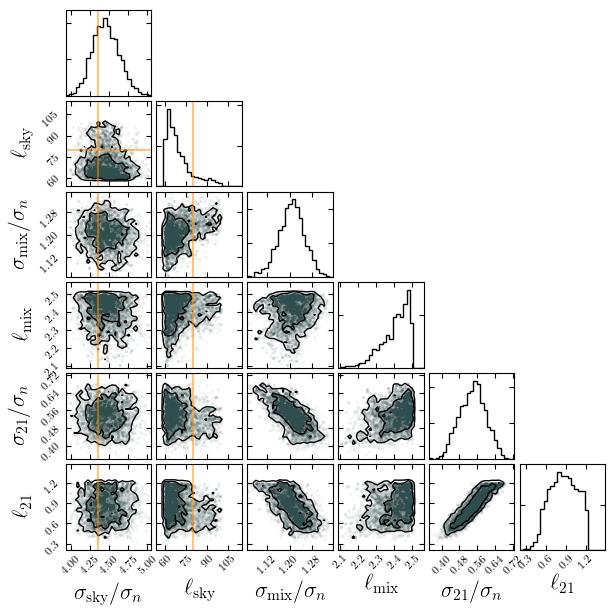

In [1086]:
i = 1
ndims = chains[i].shape[-1]
fig, axes = plt.subplots(ndims, ndims, figsize=(6, 6), dpi=100)

corner_plot(chains[i], new_labels[i], truths=truths[i], fig=fig, thin=1,
            bins=25, levels=[0.68, 0.95],
            plot_density=False, no_fill_contours=True, plot_datapoints=True,
            data_kwargs={'color':'darkslategrey','alpha':0.02},
            contour_kwargs={'colors':'k', 'linewidths':1})

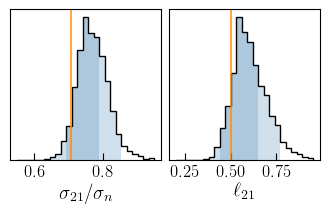

In [719]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=100)
fig.subplots_adjust(wspace=0.05)
i = 0

ax = axes[0]
ax.tick_params(labelsize=12, direction='in', size=5)
ax.set_yticks([])
hist_ci(ax, chains[i][:, -2], 25, (0.55, 0.95), ci=intervals[i][-2])
ax.set_xlabel(new_labels[0][-2], fontsize=14)
ax.axvline(truths[i][-2], color='darkorange', lw=1.5, alpha=0.75)

ax = axes[1]
ax.tick_params(labelsize=12, direction='in', size=5)
ax.set_yticks([])
hist_ci(ax, chains[i][:, -1], 25, (0.2, 0.95), ci=intervals[i][-1])
ax.set_xlabel(new_labels[i][-1], fontsize=14)
ax.axvline(truths[i][-1], color='darkorange', lw=1.5, alpha=0.75)

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-1, 5)

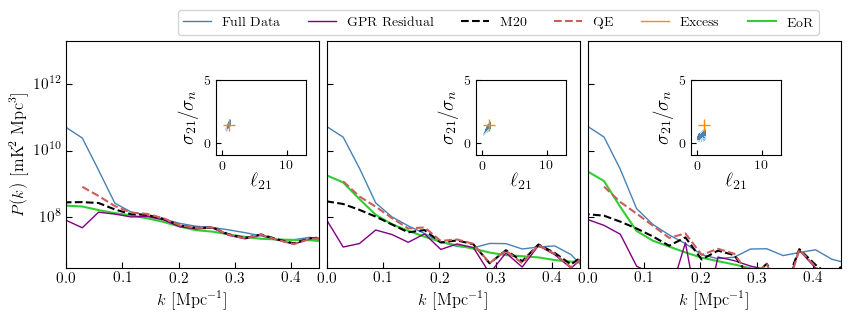

In [263]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
fig.subplots_adjust(wspace=0.03, hspace=0.4)

bbox = dict(fc='w', ec='grey', alpha=0.9, pad=5, lw=.5)
xlim = 0, 0.45
ylim = 3e6, 2e13
#ylim = 1.01e6, 5e11

norm = d.scalar / np.median(d.H.sum(axis=1))
Nb = np.mean(N[0].q + 0*X[0].q) * norm
letters = 'abcdefg'

ax = axes[0]
k = 0
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm * NEB**2, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p4, = ax.plot(D[k].kp, np.mean(X[k].q, axis=1) * norm, c='darkorange', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0.02
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 0*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
ax.legend([p1, p3, p5, p6, p4, p2],
          ["Full Data", "GPR Residual", "M20", "QE", "Excess", "EoR"],
          fontsize=10, ncol=6, bbox_to_anchor=(3, 1.17))
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$", fontsize=12)
#ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)

hax = fig.add_axes([0.275, 0.5, 0.09, 0.25])
hax.tick_params(labelsize=10, direction='in')
corner.hist2d(chains[k][:, -1], chains[k][:, -2], bins=25, ax=hax, levels=[0.68, 0.95],
              plot_datapoints=False, plot_density=False, fill_contours=True,
              data_kwargs={'color':'darkslategrey','alpha':0.02},
              contour_kwargs={'colors':'k', 'linewidths':0.}, color='steelblue')
hax.set_xlabel(new_labels[k][-1], fontsize=14, labelpad=3)
hax.set_ylabel(new_labels[k][-2], fontsize=14, labelpad=3)
hax.plot(truths[k][-1], truths[k][-2], color='darkorange', marker='+', ms=8)
hax.set_xlim(-1, 13); hax.set_ylim(-1, 5)

ax = axes[1]
k = 1
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm * NEB**2, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p4, = ax.plot(D[k].kp, np.mean(X[k].q, axis=1) * norm, c='darkorange', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0.02
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 0*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_yticklabels([])
#ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)

hax = fig.add_axes([0.535, 0.5, 0.09, 0.25])
hax.tick_params(labelsize=10, direction='in')
#hax.axvspan(0.1, 1.2, transform=ax.transAxes, color='k', alpha=0.1)
corner.hist2d(chains[k][:, -1], chains[k][:, -2], bins=25, ax=hax, levels=[0.68, 0.95],
              plot_datapoints=False, plot_density=False, fill_contours=True,
              data_kwargs={'color':'darkslategrey','alpha':0.02},
              contour_kwargs={'colors':'k', 'linewidths':0.}, color='steelblue')
hax.set_xlabel(new_labels[k][-1], fontsize=14, labelpad=3)
hax.set_ylabel(new_labels[k][-2], fontsize=14, labelpad=3)
hax.plot(truths[k][-1], truths[k][-2], color='darkorange', marker='+', ms=8)
#hax.axhline(truths[k][-2], color='darkorange', lw=1); hax.axvline(truths[k][-1], color='darkorange', lw=1)
hax.set_xlim(-1, 13); hax.set_ylim(-1, 5)

ax = axes[2]
k = 2
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm * NEB**2, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p4, = ax.plot(D[k].kp, np.mean(X[k].q, axis=1) * norm, c='darkorange', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0.02
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 0*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_yticklabels([])
#ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)

hax = fig.add_axes([0.75, 0.5, 0.09, 0.25])
hax.tick_params(labelsize=10, direction='in')
#hax.axvspan(0.1, 1.2, transform=ax.transAxes, color='k', alpha=0.1)
corner.hist2d(chains[k][:, -1], chains[k][:, -2], bins=25, ax=hax, levels=[0.68, 0.95],
              plot_datapoints=False, plot_density=False, fill_contours=True,
              data_kwargs={'color':'darkslategrey','alpha':0.02},
              contour_kwargs={'colors':'k', 'linewidths':0.}, color='steelblue')
hax.set_xlabel(new_labels[k][-1], fontsize=14, labelpad=3)
hax.set_ylabel(new_labels[k][-2], fontsize=14, labelpad=3)
hax.plot(truths[k][-1], truths[k][-2], color='darkorange', marker='+', ms=8)
#hax.axhline(truths[k][-2], color='darkorange', lw=1); hax.axvline(truths[k][-1], color='darkorange', lw=1)
hax.set_xlim(-1, 13); hax.set_ylim(-1, 5)


#fig.savefig('plots/lofar_pspec_test1.pdf', dpi=100, bbox_inches='tight')

## fg, excess, eor and noise

In [42]:
%%time
# M20 FG, EoR, Excess, Noise
D, G, E, S, F, N, X = [], [], [], [], [], [], []
Ntimes, Nuv = 1, 200
nvar = 1e-5
ell_eor = [1.0, 15, 15]
var_eor = [2.5, 30, 30]

for i, (e_ell, e_var) in enumerate(zip(ell_eor, var_eor)):
    ell_bounds = [0.1, 1.2]
    if i == 2:
        ell_bounds = [0.1, 20]
    # setup data
    (g, d, f, e, x, n,
     Knames) = setup_gpr_data(freqs, nvar=nvar, ncoeff=2, Ntimes=Ntimes, Nuv=Nuv,
                              ell_eor=e_ell, var_eor=e_var, ell_bounds=ell_bounds,
                              sky_var=610, sky_len=48, sky_len_bounds=(10, 100),
                              mix_var=50, mix_len=3, mix_len_bounds=(1, 10),
                              ex_var=2, ex_len=.26, ex_len_bounds=(.2, .8))            
    s = copy.deepcopy(d)

    # setup priors
    #g.theta_priors = [None, None, None, None, None, None, None, None, gp_utils.log_gauss(0.5, 0.05)]
    g.theta_priors = None
    
    # optimize kernel
    yfit = g.prep_ydata(freqs[:, None] / 1e6, d.x1.T)
    init_theta = g.kernel.theta.copy()
    init_theta[-1] = np.log(0.5)
    g.fit(freqs[:, None] / 1e6, yfit, init_theta=init_theta)

    # QE
    pspec_run(d, 'gpr', g.kernel_, Knames[1], norm='H^-1/2', Ntimes=Ntimes, Nuv=Nuv)
    pspec_run(e, 'I')
    pspec_run(s, 't')
    pspec_run(f, 't')
    pspec_run(n, 'I')
    pspec_run(x, 'I')

    G.append(g)
    D.append(d); E.append(e); S.append(s); F.append(f); N.append(n); X.append(x)

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


CPU times: user 3min 29s, sys: 3min 9s, total: 6min 38s
Wall time: 56.3 s


In [43]:
G[0].kernel

WhiteKernel(noise_level=2e-05) + 0.0781**2 * RBF(length_scale=48) + 0.0224**2 * Matern(length_scale=3, nu=1.5) + 0.00447**2 * Matern(length_scale=0.26, nu=2.5) + 0.005**2 * Matern(length_scale=1, nu=0.5)

In [44]:
G[0].kernel_

WhiteKernel(noise_level=2e-05) + 0.0759**2 * RBF(length_scale=37.7) + 0.0216**2 * Matern(length_scale=3.08, nu=1.5) + 0.00445**2 * Matern(length_scale=0.277, nu=2.5) + 0.00583**2 * Matern(length_scale=1.2, nu=0.5)

In [45]:
print(np.array([np.exp(g.kernel.theta[-2:]) for g in G]))
print(np.array([np.exp(g.kernel_.theta[-2:]) for g in G]))

[[2.5e-05 1.0e+00]
 [3.0e-04 1.5e+01]
 [3.0e-04 1.5e+01]]
[[3.39480032e-05 1.20000000e+00]
 [2.88399612e-05 1.20000000e+00]
 [4.77789398e-04 2.00000000e+01]]


In [46]:
init_theta = np.exp(G[0].kernel.theta)
samplers = MCMC(G, D, nstep=800, init_theta=init_theta)

running iteration 0


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


running iteration 1


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


running iteration 2


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


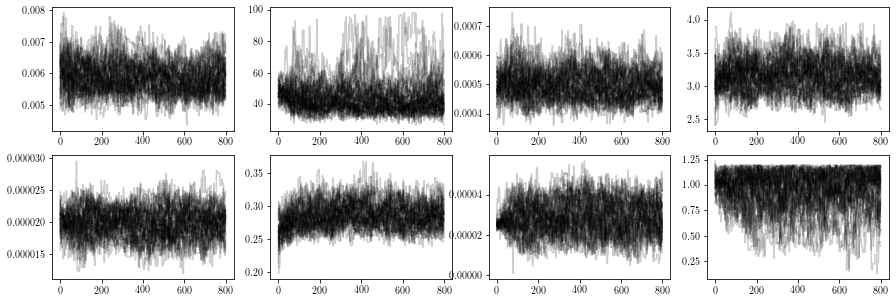

In [94]:
fig, axes = plt.subplots(2, 4, figsize=(15, 5))
k = 0
for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.plot(samplers[0].chain[:, :, k].T, c='k', alpha=0.2)
        k += 1

In [47]:
(chains, truths, new_labels, modes,
 intervals) = analyze_chain(samplers, nburn=200, ci=[0.95, 0.68], norm_inds=[0,2,4,6])

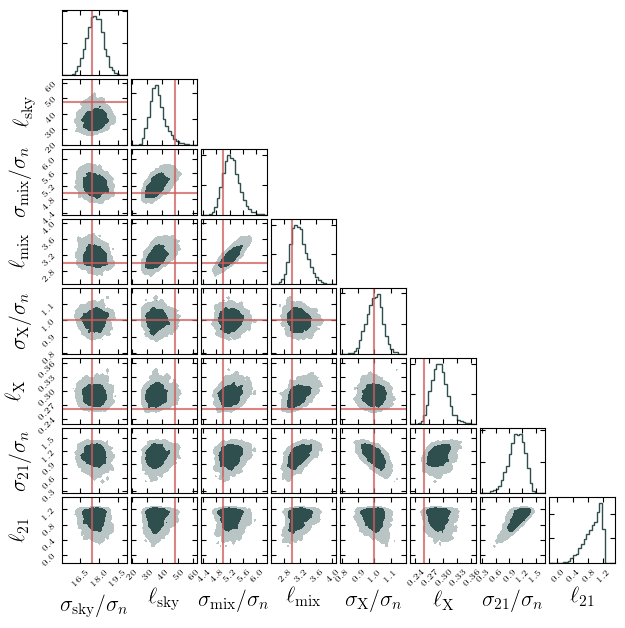

In [96]:
i = 1
ndims = chains[i].shape[-1]
fig, axes = plt.subplots(ndims, ndims, figsize=(6, 6), dpi=100)

corner_plot(chains[i], new_labels[i], truths=truths[i], fig=fig, thin=1, tls=7, buff=2.5,
            bins=25, levels=[0.68, 0.95], color='darkslategrey',
            plot_density=False, fill_contours=True, plot_datapoints=False, 
            contour_kwargs={'alpha':0})

#fig.savefig(, dpi=100, bbox_inches='tight')

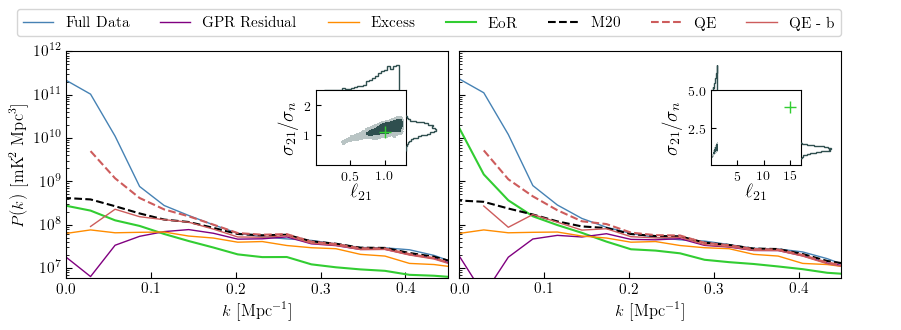

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=100)
fig.subplots_adjust(wspace=0.03, hspace=0.4)

bbox = dict(fc='w', ec='grey', alpha=0.9, pad=5, lw=.5)
xlim = 0, 0.45
ylim = 6e6, 1e12
#ylim = 1.01e6, 5e11

norm = d.scalar / np.median(d.H.sum(axis=1))
Nb = np.mean(N[0].q + 0*X[0].q) * norm
letters = 'abcdefg'

ax = axes[0]
k = 0
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * S[k].NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p4, = ax.plot(D[k].kp, np.mean(X[k].q, axis=1) * norm, c='darkorange', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 0*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
p7, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 1*D[k].b[s], axis=1) - Nb), c='indianred', lw=1., ls='-')
ax.legend([p1, p3, p4, p2, p5, p6, p7],
          ["Full Data", "GPR Residual", "Excess", "EoR", "M20", "QE", "QE - b"],
          fontsize=11, ncol=7, bbox_to_anchor=(2.05, 1.22))
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$", fontsize=12)
#ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)
#ax.axvline(0.075, c='k')

haxes = gen_axes(fig, 2, lower_left=(0.375, 0.5), dwidth=0.09, dheight=0.25)
hxlim = 0.01, 1.3; hylim = 0.01, 2.5
haxes[0, 0].axis('off'); haxes[0, 1].axis('off'); haxes[1, 1].axis('off')
hax = haxes[1, 0]
hax.tick_params(labelsize=10, direction='in')
corner.hist2d(chains[k][:, -1], chains[k][:, -2], bins=25, ax=hax, levels=[0.68, 0.95],
              plot_datapoints=False, plot_density=False, fill_contours=True,
              data_kwargs={'color':'darkslategrey','alpha':0.02},
              contour_kwargs={'colors':'k', 'linewidths':0.}, color='darkslategrey')
hax.set_xlabel(new_labels[k][-1], fontsize=14, labelpad=3)
hax.set_ylabel(new_labels[k][-2], fontsize=14, labelpad=3)
hax.plot(truths[k][-1], truths[k][-2], color='limegreen', marker='+', ms=8)
hax.set_xlim(hxlim); hax.set_ylim(hylim)
hax = haxes[0, 0]
out = hax.hist(chains[k][:, -1], bins=25, density=True, histtype='step', lw=1,
               color='darkslategrey')
hax.set_xlim(hxlim); hax.set_ylim(0, out[0].max() * 3)
hax = haxes[1, 1]
out = hax.hist(chains[k][:, -2], bins=25, density=True, histtype='step', lw=1,
               orientation='horizontal', color='darkslategrey')
hax.set_xlim(0, out[0].max() * 3); hax.set_ylim(hylim)

ax = axes[1]
k = 1
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * S[k].NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p4, = ax.plot(D[k].kp, np.mean(X[k].q, axis=1) * norm, c='darkorange', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 0*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
p7, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 1*D[k].b[s], axis=1) - Nb), c='indianred', lw=1., ls='-')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_yticklabels([])
#ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)
#ax.axvline(0.075, c='k')

haxes = gen_axes(fig, 2, lower_left=(0.77, 0.5), dwidth=0.09, dheight=0.25)
hxlim = 0.01, 17; hylim = 0.01, 5
haxes[0, 0].axis('off'); haxes[0, 1].axis('off'); haxes[1, 1].axis('off')
hax = haxes[1, 0]
hax.tick_params(labelsize=10, direction='in')
#hax.axvspan(0.1, 1.2, transform=ax.transAxes, color='k', alpha=0.1)
corner.hist2d(chains[k][:, -1], chains[k][:, -2], bins=25, ax=hax, levels=[0.68, 0.95],
              plot_datapoints=False, plot_density=False, fill_contours=True,
              data_kwargs={'color':'darkslategrey','alpha':0.02},
              contour_kwargs={'colors':'k', 'linewidths':0.}, color='darkslategrey')
hax.set_xlabel(new_labels[k][-1], fontsize=14, labelpad=3)
hax.set_ylabel(new_labels[k][-2], fontsize=14, labelpad=3)
hax.plot(truths[k][-1], truths[k][-2], color='limegreen', marker='+', ms=8)
#hax.axhline(truths[k][-2], color='darkorange', lw=1); hax.axvline(truths[k][-1], color='darkorange', lw=1)
hax.set_xlim(hxlim); hax.set_ylim(hylim)
hax = haxes[0, 0]
out = hax.hist(chains[k][:, -1], bins=25, density=True, histtype='step', lw=1,
               color='darkslategrey')
hax.set_xlim(hxlim); hax.set_ylim(0, out[0].max() * 3)
hax = haxes[1, 1]
out = hax.hist(chains[k][:, -2], bins=25, density=True, histtype='step', lw=1,
               orientation='horizontal', color='darkslategrey')
hax.set_xlim(0, out[0].max() * 3); hax.set_ylim(hylim)

#fig.savefig('plots/lofar_pspec_prior_test.pdf', dpi=100, bbox_inches='tight')

## eor power law

In [90]:
%%time
# variable EoR power law model
Ntimes, Nuv = 1, 150
nvar = 4e-5
D, G, E, S, F, N, X = [], [], [], [], [], [], []

pl_eor = [-1.8, -1.8, -1.8, -2.8, -2.8, -2.8]
var_eor = [1e-2, 2e-2, 4e-2, 5e-6, 15e-6, 45e-6]

for i, (e_pl, e_var) in enumerate(zip(pl_eor, var_eor)):
    # setup data
    (g, d, f, e, x, n,
     Knames) = setup_gpr_data(freqs, nvar=nvar, PL_eor=e_pl, ell_eor_seed=0.5, var_eor=e_var,
                                              ell_bounds=[0.1, 1.2], ncoeff=1, Ntimes=Ntimes, Nuv=Nuv)
    s = copy.deepcopy(d)
    
    # optimize kernel
    g.fit(freqs[:, None] / 1e6, g.prep_ydata(freqs[:, None] / 1e6, d.x1.T))

    # get estimated cov matrices
    Cf = gp_utils.get_kernel(g.kernel_, Knames[1])(freqs[:, None]/1e6) * 2
    Cd = g.kernel_(freqs[:, None]/1e6) * 2

    # QE
    t = np.diag(uvt.dspec.gen_window('bh', Nfreqs))
    NEB = hc.vis_clean.noise_eq_bandwidth(t.diagonal())
    I = np.eye(Nfreqs)
    gpr = (I - Cf @ np.linalg.pinv(Cd))
    cov_err = (Cf - Cf @ np.linalg.inv(Cd) @ Cf)
    pspec_run(d, gpr, norm='H^-1/2', C_bias=Cf, C_data=Cd, cov_err=cov_err, Ntimes=Ntimes, Nuv=Nuv)
    pspec_run(e, t)
    pspec_run(s, t)
    pspec_run(f, t)
    pspec_run(n, I)
    pspec_run(x, I)

    G.append(g)
    D.append(d); E.append(e); S.append(s); F.append(f); N.append(n); X.append(x)

covariance is not symmetric positive-semidefinite.
invalid value encountered in true_divide
covariance is not symmetric positive-semidefinite.
invalid value encountered in true_divide
covariance is not symmetric positive-semidefinite.
invalid value encountered in true_divide
covariance is not symmetric positive-semidefinite.
invalid value encountered in true_divide
covariance is not symmetric positive-semidefinite.
invalid value encountered in true_divide
covariance is not symmetric positive-semidefinite.
invalid value encountered in true_divide


CPU times: user 6min, sys: 5min 11s, total: 11min 11s
Wall time: 1min 24s


Casting complex values to real discards the imaginary part


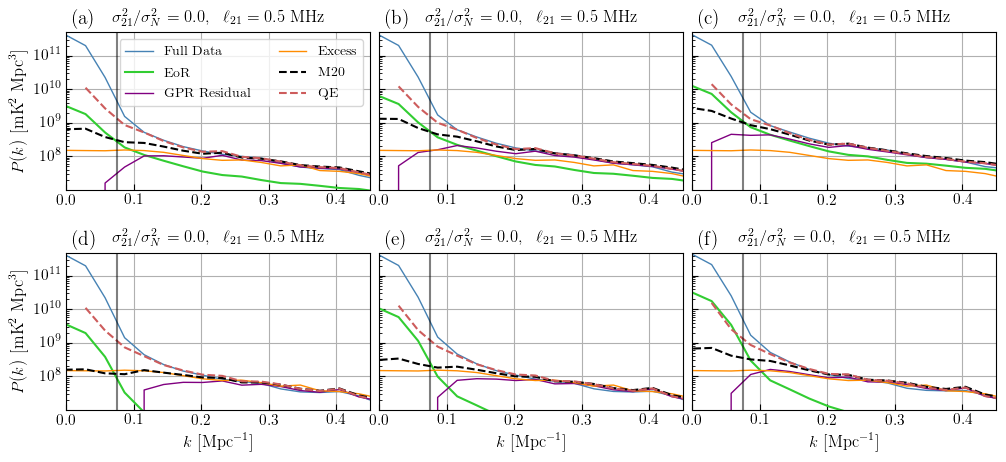

In [91]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5), dpi=100)
fig.subplots_adjust(wspace=0.03, hspace=0.4)

bbox = dict(fc='w', ec='grey', alpha=0.9, pad=5, lw=.5)
xlim = 0, 0.45
ylim = 1.01e7, 5e11

#xlim = 1e-2, 2e0
#ylim = 1.01e5, 5e11

norm = d.scalar / np.median(d.H.sum(axis=1))
Nb = np.mean(n.q) * norm
letters = 'abcdefg'

k = 0
for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        ax.tick_params(labelsize=11, direction='in', size=4)
        ax.tick_params(direction='in', which='minor', size=2)
        p1, = ax.plot(S[k].kp, np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb, c='steelblue', lw=1, ls='-')
        p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm * NEB**2, c='limegreen', lw=1.5, ls='-')
        p3, = ax.plot(D[k].kp, np.mean(D[k].q, axis=1) * norm - Nb, c='purple', lw=1, ls='-')
        p4, = ax.plot(D[k].kp, np.mean(X[k].q, axis=1) * norm, c='darkorange', lw=1, ls='-')
        p5, = ax.plot(D[k].kp, np.mean(D[k].q_corr, axis=1) * norm - Nb, c='k', lw=1.5, ls='--')
        s = D[k].kp > 0.02
        p6, = ax.plot(D[k].kp[s], np.mean(D[k].p[s] - 0*D[k].b[s], axis=1) - Nb, c='indianred', lw=1.5, ls='--')
        
        if k == 0:
            ax.legend([p1, p2, p3, p4, p5, p6],
                      ["Full Data", "EoR", "GPR Residual", "Excess", "M20", "QE"],
                      fontsize=10, ncol=2)
        #ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid()
        if i == 0:
            pass
        else:
            ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
        if j == 0:
            ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$", fontsize=12)
        else:
            ax.set_yticklabels([])
        nvar = np.e**gp_utils.get_kernel(G[k].kernel, Knames[0]).theta[0] / 1.2
        eor_var = np.e**gp_utils.get_kernel(G[k].kernel, Knames[-1]).theta[0] / nvar
        eor_ell = np.e**gp_utils.get_kernel(G[k].kernel, Knames[-1]).theta[1]
        ax.set_title(r"$\sigma_{{21}}^2/\sigma_N^2={:.1f},\ \ \ell_{{21}}={:.1f}\ {{\rm MHz}}$" \
                     "".format(eor_var, eor_ell), fontsize=12, y=0.98)
        ax.text(0.02, 1.05, '('+letters[k]+')', fontsize=14, transform=ax.transAxes, weight='bold')
        ax.plot(n.kp, np.mean(n.q, axis=1)/np.sqrt(200)*norm, c='c')
        ax.axvline(0.075, c='k', alpha=0.5)
        k += 1
        
#fig.savefig('plots/lofar_simulated_recovery.pdf', dpi=100, bbox_inches='tight')

In [ ]:
%%time
# variable Matern and PL
Ntimes, Nuv = 1, 150
nvar = 4e-5
D, G, E, S, F, N, X = [], [], [], [], [], [], []

pl_eor = [None, None, None, -2.8, -2.8, -2.8]
ell_eor = []
var_eor = [1e-2, 2e-2, 4e-2, 5e-6, 15e-6, 45e-6]

for i, (e_pl, e_var) in enumerate(zip(pl_eor, var_eor)):
    # setup data
    (g, d, f, e, x, n,
     Knames) = setup_gpr_data(freqs, nvar=nvar, PL_eor=e_pl, ell_eor_seed=0.5, var_eor=e_var,
                                              ell_bounds=[0.1, 1.2], ncoeff=1, Ntimes=Ntimes, Nuv=Nuv)
    s = copy.deepcopy(d)
    
    # optimize kernel
    g.fit(freqs[:, None] / 1e6, g.prep_ydata(freqs[:, None] / 1e6, d.x1.T))

    # get estimated cov matrices
    Cf = gp_utils.get_kernel(g.kernel_, Knames[1])(freqs[:, None]/1e6) * 2
    Cd = g.kernel_(freqs[:, None]/1e6) * 2

    # QE
    t = np.diag(uvt.dspec.gen_window('bh', Nfreqs))
    NEB = hc.vis_clean.noise_eq_bandwidth(t.diagonal())
    I = np.eye(Nfreqs)
    gpr = (I - Cf @ np.linalg.pinv(Cd))
    d.set_R(gpr); d.compute_Q(); d.compute_H(); d.compute_q(); d.compute_MWVp(norm='H^-1/2', C_bias=Cf)
    e.set_R(t); e.compute_Q(); e.compute_H(); e.compute_q(); e.compute_MWVp(norm='I')
    s.set_R(t); s.compute_Q(); s.compute_H(); s.compute_q(); s.compute_MWVp(norm='I')
    f.set_R(t); f.compute_Q(); f.compute_H(); f.compute_q(); f.compute_MWVp(norm='I')
    n.set_R(I); n.compute_Q(); n.compute_H(); n.compute_q(); n.compute_MWVp(norm='I')
    x.set_R(I); x.compute_Q(); x.compute_H(); x.compute_q(); x.compute_MWVp(norm='I')

    # LOFAR GPR
    cov_err = (Cf - Cf @ np.linalg.pinv(Cd) @ Cf)
    ce = mn.rvs(np.zeros(Nfreqs), cov_err/2, Ntimes*Nuv) + 1j * mn.rvs(np.zeros(Nfreqs), cov_err/2, Ntimes*Nuv)
    ce = sqe.QE(freqs, ce, C=cov_err, Omega_Eff=Oeff * Jy2mK**2)
    ce.set_R(I); ce.compute_Q(); ce.compute_H(); ce.compute_q()
    d.q_corr = d.q + ce.q

    G.append(g)
    D.append(d); E.append(e); S.append(s); F.append(f); N.append(n); X.append(x)

In [27]:
freqs = np.linspace(130e6, 150e6, 100)
Nfreqs = len(freqs)
I = np.eye(len(freqs))
_, _, _, e1, _, _, _ = setup_gpr_data(freqs, PL_eor=-2.8, var_eor=1, ncoeff=1, Nuv=300)
_, _, _, e2, _, _, _ = setup_gpr_data(freqs, ell_eor=1.0, var_eor=1, ncoeff=1, Nuv=300)
_, _, _, e3, _, _, _ = setup_gpr_data(freqs, ell_eor=4.0, var_eor=1, ncoeff=1, Nuv=300)
_, _, f4, e4, x4, _, _ = setup_gpr_data(freqs, ncoeff=1, Nuv=300, sky_len=3, mix_var=1e-10, ex_len=3)

e1.set_R(I); e1.compute_Q(); e1.compute_H(); e1.compute_q(); e1.compute_MWVp()
e2.set_R(I); e2.compute_Q(); e2.compute_H(); e2.compute_q(); e2.compute_MWVp()
e3.set_R(I); e3.compute_Q(); e3.compute_H(); e3.compute_q(); e3.compute_MWVp()
e4.set_R(I); e4.compute_Q(); e4.compute_H(); e4.compute_q(); e4.compute_MWVp()
f4.set_R(I); f4.compute_Q(); f4.compute_H(); f4.compute_q(); f4.compute_MWVp()
x4.set_R(I); x4.compute_Q(); x4.compute_H(); x4.compute_q(); x4.compute_MWVp()

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


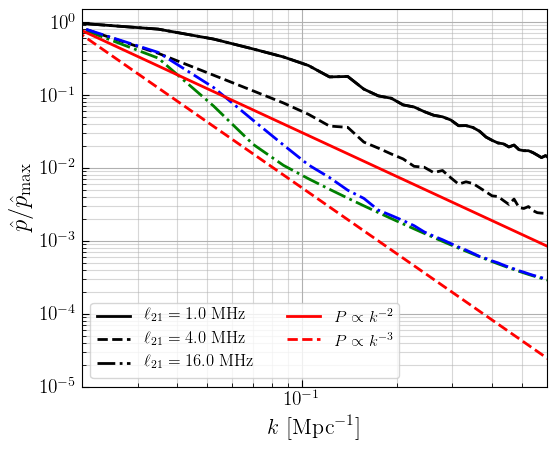

In [28]:
e1p = np.mean(e1.p.real, axis=1)
e2p = np.mean(e2.p.real, axis=1)
e3p = np.mean(e3.p.real, axis=1)
e4p = np.mean(e4.p.real, axis=1)
f4p = np.mean(f4.p.real, axis=1)
x4p = np.mean(x4.p.real, axis=1)

k2 = e1.kp**-2
k3 = e1.kp**-3

s = np.argmin(np.abs(e1.kp - .02))
k2 /= k2[s]
k3 /= k3[s]
e2p /= e2p[s]
e3p /= e3p[s]
e4p /= e4p[s]
f4p /= f4p[s]
x4p /= x4p[s]

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.tick_params(labelsize=14, direction='in', size=5, which='major')
ax.tick_params(direction='in', size=3, which='minor')

ax.plot(e2.kp, e2p, c='k', ls='-', lw=2, label=r'$\ell_{21}=1.0\ {\rm MHz}$')
ax.plot(e3.kp, e3p, c='k', ls='--', lw=2, label=r'$\ell_{21}=4.0\ {\rm MHz}$')
ax.plot(e4.kp, e4p, c='k', ls='-.', lw=2, label=r'$\ell_{21}=16.0\ {\rm MHz}$')
ax.plot(f4.kp, f4p, c='g', ls='-.', lw=2, label=r'')
ax.plot(f4.kp, x4p, c='b', ls='-.', lw=2, label=r'')

ax.plot(e3.kp, k2, c='r', ls='-', lw=2, label=r'$P\propto k^{-2}$')
ax.plot(e4.kp, k3, c='r', ls='--', lw=2, label=r'$P\propto k^{-3}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2e-2, 0.6)
ax.set_ylim(1e-5, 1.5e0)
ax.grid(which='major')
ax.grid(which='minor', ls='-', alpha=0.5)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$\hat{p} / \hat{p}_{\rm max}$', fontsize=18)
ax.legend(fontsize=12, ncol=2)

#fig.savefig("plots/eor_covariance_power_law.pdf", dpi=100, bbox_inches='tight')

## tone injection

In [319]:
%%time
# M20 FG, EoR, Excess, Noise
D, G, E, S, F, N, X = [], [], [], [], [], [], []
Ntimes, Nuv = 1, 200
nvar = 1e-5
var_tone = [0.2, 1, 5]

for i, v_tone in enumerate(var_tone):
    # setup data
    (g, d, f, e, x, n,
     Knames) = setup_gpr_data(freqs, nvar=nvar, ncoeff=2, Ntimes=Ntimes, Nuv=Nuv,
                              ell_eor=1.0, var_eor=2, ell_bounds=[0.1, 1.2],
                              var_tone=v_tone, k_tone=0.085,
                              sky_var=610, sky_len=48, sky_len_bounds=(10, 100),
                              mix_var=50, mix_len=3, mix_len_bounds=(1, 10),
                              ex_var=2, ex_len=.26, ex_len_bounds=(.2, .8))            
    s = copy.deepcopy(d)

    # setup priors
    #g.theta_priors = [None, None, None, None, None, None, None, None, gp_utils.log_gauss(0.5, 0.05)]
    g.theta_priors = None
    
    # optimize kernel
    #g.n_restarts_optimizer = 20
    yfit = g.prep_ydata(freqs[:, None] / 1e6, d.x1.T)
    g.fit(freqs[:, None] / 1e6, yfit)

    # QE
    pspec_run(d, 'gpr', g.kernel_, Knames[1], norm='H^-1/2', Ntimes=Ntimes, Nuv=Nuv)
    pspec_run(e, 'I')
    pspec_run(s, 't')
    pspec_run(f, 't')
    pspec_run(n, 'I')
    pspec_run(x, 'I')

    G.append(g)
    D.append(d); E.append(e); S.append(s); F.append(f); N.append(n); X.append(x)

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


CPU times: user 3min 25s, sys: 2min 55s, total: 6min 21s
Wall time: 50 s


In [42]:
print(np.array([np.exp(g.kernel.theta[-2:]) for g in G]))
print(np.array([np.exp(g.kernel_.theta[-2:]) for g in G]))

[[2.e-05 1.e+00]
 [2.e-05 1.e+00]
 [2.e-05 1.e+00]]
[[2.14085831e-05 1.20000000e+00]
 [1.37469668e-06 1.00000000e-01]
 [2.00000000e-07 1.28226421e-01]]


In [320]:
init_theta = np.exp(G[0].kernel.theta)
samplers = MCMC(G, D, nstep=800, init_theta=init_theta)

running iteration 0


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


running iteration 1


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


running iteration 2


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


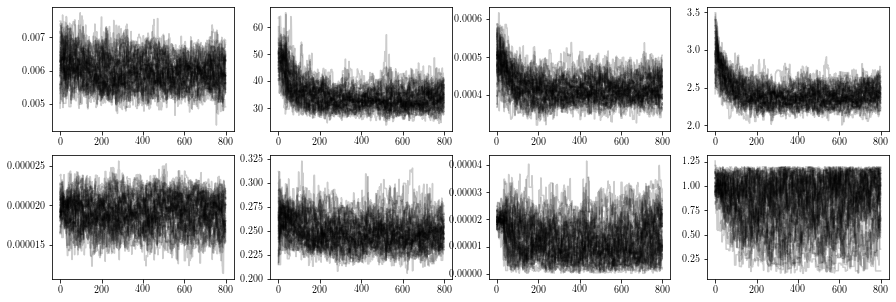

In [322]:
fig, axes = plt.subplots(2, 4, figsize=(15, 5))
k = 0
for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.plot(samplers[1].chain[:, :, k].T, c='k', alpha=0.2)
        k += 1

In [329]:
(chains, truths, new_labels, modes,
 intervals) = analyze_chain(samplers, nburn=200, ci=[0.95, 0.68], norm_inds=[0,2,4,6])

(0.01, 2.5)

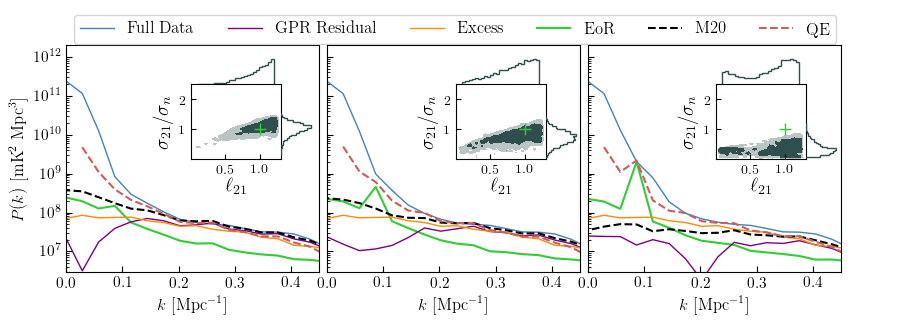

In [330]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
fig.subplots_adjust(wspace=0.03, hspace=0.4)

bbox = dict(fc='w', ec='grey', alpha=0.9, pad=5, lw=.5)
xlim = 0, 0.45
ylim = 3e6, 2e12
#ylim = 1.01e6, 5e11

hxlim = 0.01, 1.3
hylim = 0.01, 2.5

norm = d.scalar / np.median(d.H.sum(axis=1))
Nb = np.mean(N[0].q + 0*X[0].q) * norm
NEB = S[0].NEB
letters = 'abcdefg'

ax = axes[0]
k = 0
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p4, = ax.plot(D[k].kp, np.mean(X[k].q, axis=1) * norm, c='darkorange', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0.02
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 0*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
ax.legend([p1, p3, p4, p2, p5, p6],
          ["Full Data", "GPR Residual", "Excess", "EoR", "M20", "QE"],
          fontsize=12, ncol=6, bbox_to_anchor=(3.075, 1.17))
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$", fontsize=12)
ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)

haxes = gen_axes(fig, 2, lower_left=(0.25, 0.5), dwidth=0.09, dheight=0.25)
haxes[0, 0].axis('off'); haxes[0, 1].axis('off'); haxes[1, 1].axis('off')
hax = haxes[1, 0]
hax.tick_params(labelsize=10, direction='in')
corner.hist2d(chains[k][:, -1], chains[k][:, -2], bins=25, ax=hax, levels=[0.68, 0.95],
              plot_datapoints=False, plot_density=False, fill_contours=True,
              data_kwargs={'color':'darkslategrey','alpha':0.02},
              contour_kwargs={'colors':'k', 'linewidths':0.}, color='darkslategrey')
hax.set_xlabel(new_labels[k][-1], fontsize=14, labelpad=3)
hax.set_ylabel(new_labels[k][-2], fontsize=14, labelpad=3)
hax.plot(truths[k][-1], truths[k][-2], color='limegreen', marker='+', ms=8)
hax.set_xlim(hxlim); hax.set_ylim(hylim)
hax = haxes[0, 0]
out = hax.hist(chains[k][:, -1], bins=25, density=True, histtype='step', lw=1,
               color='darkslategrey')
hax.set_xlim(hxlim); hax.set_ylim(0, out[0].max() * 3)
hax = haxes[1, 1]
out = hax.hist(chains[k][:, -2], bins=25, density=True, histtype='step', lw=1,
               orientation='horizontal', color='darkslategrey')
hax.set_xlim(0, out[0].max() * 3); hax.set_ylim(hylim)

ax = axes[1]
k = 1
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p4, = ax.plot(D[k].kp, np.mean(X[k].q, axis=1) * norm, c='darkorange', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0.02
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 0*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_yticklabels([])
ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)

haxes = gen_axes(fig, 2, lower_left=(0.515, 0.5), dwidth=0.09, dheight=0.25)
haxes[0, 0].axis('off'); haxes[0, 1].axis('off'); haxes[1, 1].axis('off')
hax = haxes[1, 0]
hax.tick_params(labelsize=10, direction='in')
#hax.axvspan(0.1, 1.2, transform=ax.transAxes, color='k', alpha=0.1)
corner.hist2d(chains[k][:, -1], chains[k][:, -2], bins=25, ax=hax, levels=[0.68, 0.95],
              plot_datapoints=False, plot_density=False, fill_contours=True,
              data_kwargs={'color':'darkslategrey','alpha':0.02},
              contour_kwargs={'colors':'k', 'linewidths':0.}, color='darkslategrey')
hax.set_xlabel(new_labels[k][-1], fontsize=14, labelpad=3)
hax.set_ylabel(new_labels[k][-2], fontsize=14, labelpad=3)
hax.plot(truths[k][-1], truths[k][-2], color='limegreen', marker='+', ms=8)
#hax.axhline(truths[k][-2], color='darkorange', lw=1); hax.axvline(truths[k][-1], color='darkorange', lw=1)
hax.set_xlim(hxlim); hax.set_ylim(hylim)
hax = haxes[0, 0]
out = hax.hist(chains[k][:, -1], bins=25, density=True, histtype='step', lw=1,
               color='darkslategrey')
hax.set_xlim(hxlim); hax.set_ylim(0, out[0].max() * 3)
hax = haxes[1, 1]
out = hax.hist(chains[k][:, -2], bins=25, density=True, histtype='step', lw=1,
               orientation='horizontal', color='darkslategrey')
hax.set_xlim(0, out[0].max() * 3); hax.set_ylim(hylim)

ax = axes[2]
k = 2
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p4, = ax.plot(D[k].kp, np.mean(X[k].q, axis=1) * norm, c='darkorange', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0.02
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 0*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_yticklabels([])
#ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)

haxes = gen_axes(fig, 2, lower_left=(0.775, 0.5), dwidth=0.09, dheight=0.25)
haxes[0, 0].axis('off'); haxes[0, 1].axis('off'); haxes[1, 1].axis('off')
hax = haxes[1, 0]
hax.tick_params(labelsize=10, direction='in')
#hax.axvspan(0.1, 1.2, transform=ax.transAxes, color='k', alpha=0.1)
corner.hist2d(chains[k][:, -1], chains[k][:, -2], bins=25, ax=hax, levels=[0.68, 0.95],
              plot_datapoints=False, plot_density=False, fill_contours=True,
              data_kwargs={'color':'darkslategrey','alpha':0.02},
              contour_kwargs={'colors':'k', 'linewidths':0.}, color='darkslategrey')
hax.set_xlabel(new_labels[k][-1], fontsize=14, labelpad=3)
hax.set_ylabel(new_labels[k][-2], fontsize=14, labelpad=3)
hax.plot(truths[k][-1], truths[k][-2], color='limegreen', marker='+', ms=8)
hax.set_xlim(hxlim); hax.set_ylim(hylim)
hax = haxes[0, 0]
out = hax.hist(chains[k][:, -1], bins=25, density=True, histtype='step', lw=1,
               color='darkslategrey')
hax.set_xlim(hxlim); hax.set_ylim(0, out[0].max() * 3)
hax = haxes[1, 1]
out = hax.hist(chains[k][:, -2], bins=25, density=True, histtype='step', lw=1,
               orientation='horizontal', color='darkslategrey')
hax.set_xlim(0, out[0].max() * 3); hax.set_ylim(hylim)

#fig.savefig('plots/lofar_pspec_tone_injection.pdf', dpi=100, bbox_inches='tight')

## FG, EoR, Noise: hard-coded EoR

In [166]:
%%time
# M20 FG, EoR, Excess, Noise
D, G, E, E2, S, F, N, X = [], [], [], [], [], [], [], []
Ntimes, Nuv = 1, 200
nvar = 1e-5
ell_eor = [1, 1, 1]
var_eor = [6, 6, 6]
ell_start = [0.5, 1.0, 4.0]
var_start = [2.0, 6.0, 18.0]

for i, (e_ell, e_var) in enumerate(zip(ell_eor, var_eor)):
    # setup data
    (g, d, f, e, x, n,
     Knames) = setup_gpr_data(freqs, nvar=nvar, ncoeff=2, Ntimes=Ntimes, Nuv=Nuv,
                              ell_eor=e_ell, var_eor=e_var, ell_bounds=[0.1, 1.2],
                              sky_var=610, sky_len=48, sky_len_bounds=(10, 100),
                              mix_var=50, mix_len=3, mix_len_bounds=(1, 10),
                              ex_var=1e-20, ex_len=.26, ex_len_bounds=(.2, .8))  
    (_, _, _, e2, _, _,
     _) = setup_gpr_data(freqs, nvar=nvar, ncoeff=2, Ntimes=Ntimes, Nuv=Nuv,
                              ell_eor=ell_start[i], var_eor=var_start[i], ell_bounds=[0.1, 1.2],
                              sky_var=610, sky_len=48, sky_len_bounds=(10, 100),
                              mix_var=50, mix_len=3, mix_len_bounds=(1, 10),
                              ex_var=1e-20, ex_len=.26, ex_len_bounds=(.2, .8))            
    s = copy.deepcopy(d)

    # setup priors
    g.theta_priors = None
    
    # optimize kernel
    yfit = g.prep_ydata(freqs[:, None] / 1e6, d.x1.T)
    _theta = g.kernel.theta
    _theta[-2:] = np.log([var_start[i] * nvar, ell_start[i]])
    kernel = g.kernel.clone_with_theta(_theta)

    # QE
    pspec_run(d, 'gpr', kernel, Knames[1], norm='H^-1/2', Ntimes=Ntimes, Nuv=Nuv)
    pspec_run(e, 'I')
    pspec_run(e2, 'I')
    pspec_run(s, 't')
    pspec_run(f, 't')
    pspec_run(n, 'I')
    pspec_run(x, 'I')
    
    G.append(g)
    D.append(d); E.append(e); E2.append(e2); S.append(s); F.append(f); N.append(n); X.append(x)

CPU times: user 2min 59s, sys: 1min 15s, total: 4min 14s
Wall time: 35 s


/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.3, 0.8, 'Over predicted\nEoR covariance')

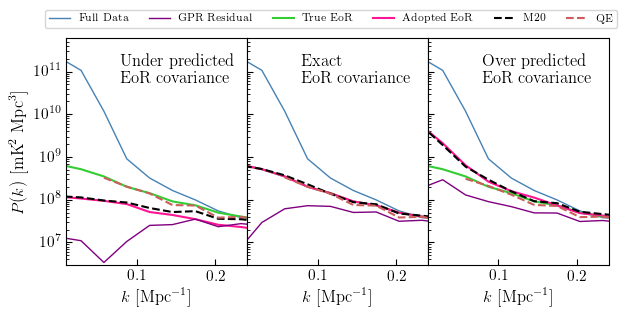

In [167]:
fig, axes = plt.subplots(1, 3, figsize=(7, 3), dpi=100)
fig.subplots_adjust(wspace=0.0, hspace=0.4)

bbox = dict(fc='w', ec='grey', alpha=0.9, pad=5, lw=.5)
xlim = 0.01, 0.24
ylim = 3e6, 6e11
#ylim = 1.01e6, 5e11

hxlim = 0.01, 1.3
hylim = 0.01, 2.5

norm = d.scalar / np.median(d.H.sum(axis=1))
Nb = np.mean(N[0].q + 0*X[0].q) * norm
NEB = S[0].NEB
letters = 'abcdefg'

ax = axes[0]
k = 0
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(E[k].kp, np.mean(E2[k].q, axis=1) * norm, c='deeppink', lw=1.5, ls='-')
p4, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0.03
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 1*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ {\rm Mpc}^3]$", fontsize=12)
ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)
ax.legend([p1, p4, p2, p3, p5, p6],
          ["Full Data", "GPR Residual", "True EoR", "Adopted EoR", "M20", "QE"],
          fontsize=7.5, ncol=6, bbox_to_anchor=(3.075, 1.15))
ax.text(0.3, 0.8, "Under predicted\nEoR covariance", fontsize=12, transform=ax.transAxes)

ax = axes[1]
k = 1
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(E[k].kp, np.mean(E2[k].q, axis=1) * norm, c='deeppink', lw=1.5, ls='-')
p4, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0.03
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 1*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_yticklabels([])
ax.axhline(np.mean(n.q)/np.sqrt(Ntimes*Nuv)*norm, c='k', alpha=0.5, lw=2)
ax.text(0.3, 0.8, "Exact\nEoR covariance", fontsize=12, transform=ax.transAxes)

ax = axes[2]
k = 2
ax.tick_params(labelsize=11, direction='in', size=4)
ax.tick_params(direction='in', which='minor', size=2)
p1, = ax.plot(S[k].kp, np.abs(np.mean(S[k].q, axis=1) * norm * NEB**2 - Nb), c='steelblue', lw=1, ls='-')
p2, = ax.plot(E[k].kp, np.mean(E[k].q, axis=1) * norm, c='limegreen', lw=1.5, ls='-')
p3, = ax.plot(E[k].kp, np.mean(E2[k].q, axis=1) * norm, c='deeppink', lw=1.5, ls='-')
p4, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q, axis=1) * norm - Nb), c='purple', lw=1, ls='-')
p5, = ax.plot(D[k].kp, np.abs(np.mean(D[k].q_corr, axis=1) * norm - Nb), c='k', lw=1.5, ls='--')
s = D[k].kp > 0.03
p6, = ax.plot(D[k].kp[s], np.abs(np.mean(D[k].p[s] - 1*D[k].b[s], axis=1) - Nb), c='indianred', lw=1.5, ls='--')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$k\ [{\rm Mpc}^{-1}]$", fontsize=12)
ax.set_yticklabels([])
ax.text(0.3, 0.8, "Over predicted\nEoR covariance", fontsize=12, transform=ax.transAxes)

#fig.savefig('plots/lofar_pspec_adopted_true_eor.pdf', dpi=100, bbox_inches='tight')

# other

Text(0.6, 0.6, '$\\left[\\begin{array}{c} \\hspace{2cm} \\\\ \\boldsymbol{C}_{,\\alpha}\\\\ \\\\ \\end{array}\\right]$')

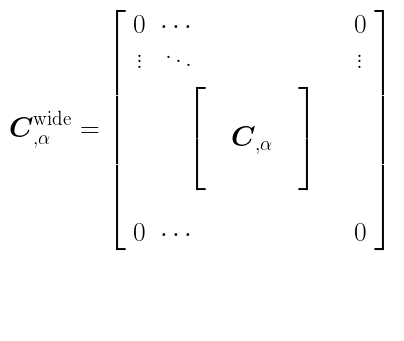

In [1462]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
ax.axis('off')
math = r"$\boldsymbol{C}_{,\alpha}^{\rm wide} = \left[\begin{array}{cc} 0 & \cdots\hspace{4cm} 0 \\ \vdots & \ddots \hspace{4cm} \vdots \\ \\ \\ \\ \\ 0 & \cdots \hspace{4cm} 0\end{array}\right]$"
ax.text(0, 0.3, math, fontsize=20, transform=ax.transAxes)
math = r"$\left[\begin{array}{c} \hspace{2cm} \\ \boldsymbol{C}_{,\alpha}\\ \\ \end{array}\right]$"
ax.text(0.6, 0.6, math, fontsize=20, transform=ax.transAxes)


In [1101]:
def obj_func(theta, g, eval_gradient=True):
    log_theta = theta # np.log(theta)
    if eval_gradient:
        lml, grad = g.log_marginal_likelihood(
            log_theta, eval_gradient=True)
        return -lml, -grad
    else:
        return -g.log_marginal_likelihood(log_theta)

In [1158]:
out = optimize.fmin_l_bfgs_b(obj_func, np.log(np.exp(g.kernel.theta)*1), args=(g,), )

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
